# imports

In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
minor = AutoMinorLocator()
import math # for tan function and degrees function

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pylab as plt
import matplotlib.patches as mpatches 

# Custom imports

In [2]:
import sys

sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
import coencodeVarious as CV
import ClassCOMPAS     as CC
import ClassFormationChannels as FC
from PostProcessingScripts import * 


# Read in the data

In [3]:
#general path to file (which I pass to the formationChannel file later)
path = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/'
pathCOMPASOutput = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/'
#specific path to use now
path1 = path+'COMPASOutput.h5'
fdata = h5.File(path1)
print(fdata.keys())

[u'RLOF', u'doubleCompactObjects', u'formationChannels', u'supernovae', u'systems']


In [ ]:
#Note above that COMPASOutput.h5 contains all the ascii files
#(if turned on in the pythonSubmit during the simulation)

#easy name for the doubleCompactObjects h5 group
fDCO      = fdata['doubleCompactObjects']

In [ ]:
#chosenMetallicity= 0.001



fDCO  = fdata['doubleCompactObjects']
fForm = fdata['formationChannels']
fSN   = fdata['supernovae']
fCE  = fdata['commonEnvelopes']

totalSystems= len((fdata['systems']['mass1'][...].squeeze()))
print(totalSystems, 'total systems simulated')
#Only want BBHs



In [ ]:
fDCO  = fdata['doubleCompactObjects']

x_ = fdata['doubleCompactObjects']['mergesInHubbleTimeFlag'][...].squeeze()
x_ = fdata['doubleCompactObjects']['optimisticCEFlag'][...].squeeze()
print(x_[x_==1])

# info about metallicities

In [ ]:
import h5py
filename = path1

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    
print(data)

print(data['weight'][...].squeeze())

# general function for given specific metallicity: 


# General Plots

In [4]:
def getvariables(var_x, var_y, model, DCOtype, boolDCOmask, metallicity):
    '''
    var_x = name of x variable we want to get (has to live in DCO file)
    var_y = name of y variable we want to get (has to live in DCO file)
    model = name of directory with data specific model e.g. Fiducial/
    DCOtype = 'BHNS' or ('BBH', 'BNS', 'ALL')
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    '''
    
    path = '/Volumes/TOSHIBA EXT/black_hole-neutron_star/' + model

    #specific path to use now
    path1 = path+'COMPASOutput.h5'
    f = h5.File(path1)
    
    fDCO  = f['doubleCompactObjects']
    fForm = f['formationChannels']
    fSN   = f['supernovae']
    fCE  = f['commonEnvelopes']

    totalSystems= len((f['systems']['mass1'][...].squeeze()))

    
    if metallicity:
        # mask specific requested metallicity  
        maskDCO_temp = maskTargetDCOsSTROOPWAFEL(DCOtype ='BHNS', boolDCOmask=[1,1,0], f=f,\
                                            otherSelection=None, otherparam=None) 
        maskDCO = (fDCO['Metallicity1'][...].squeeze() == metallicity) & (maskDCO_temp == 1)

    else:
        #Only want selected DCO type (combines all metallicities & does not mask specific metallicity)
        maskDCO = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, boolDCOmask=boolDCOmask, f=f,\
                                            otherSelection=None, otherparam=None)


    #what are the seeds of the systems that form BBHs
    seedsOfIntererst = fDCO['seed'][...].squeeze()[maskDCO]
    #Give me a bool of the lines in formation channels that form BBHs
    bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)
    weightsSystems =  f['systems']['weight'][...].squeeze()
    totalSystems = np.sum(f['systems']['weight'][...].squeeze()) # total weight of DCOs of interest
    totalSystemsDCO = np.sum(fDCO['weight'][...].squeeze()[maskDCO])



    #Because I dont want to retype the columns every time and I dont want 
    #all the data 
    metallicities    = np.log10((fDCO['Metallicity1'][...][maskDCO].squeeze())/0.0142)
    varx             = fDCO[var_x][...][maskDCO].squeeze()
    vary             = fDCO[var_y][...][maskDCO].squeeze()

    return varx, vary



In [5]:
def BHNSorNSBH(m1bh, m2bh):
    # add later on the 2nd explodes first 
    
    maskBHNS = m1bh >= m2bh # we have a BH=NS

    
    return maskBHNS

def below3Msun(m1bh):
    # add later on the 2nd explodes first 
    
    maskBHNS = m1bh <= 3 # we have a BH=NS

    
    return maskBHNS

In [6]:
def PlotZAMSmasses(ax, var_x, var_y, BHNSmask, colors, var_xlabel, var_ylabel, datalabel, ind_subchannel ):
    """Plots initial ZAMS masses of BHNS binaries
    var_x, var_y, = array with variable to plot (e.g. M1ZAMS)
    BHNSmask = mask created that =1 for BHNS systems 
    colors =  which color to use for current channel
    var_xlabel, var_ylabel = x,y axis labels of variables 
    datalabel = which label to plot for current channel
    ind_subchannel = index of the current subchannel 
    """
    
    ax.tick_params(labelsize=fs)
    ax.grid();
    
    ax.set_xlabel(var_xlabel, fontsize=fs)
    ax.set_ylabel(var_ylabel, fontsize=fs)

    

    if (ind_subchannel==0) & (datalabel!=None): # only plot label of first subchannel
        print(ind_channel, 'reaching label', datalabel)
        
        ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '', label = datalabel)
        ax.legend(markerscale=2, scatterpoints=1,fontsize=fs-5, loc='upper right', ncol=2, handletextpad=0.1)
    else:
        ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '')
    
#     ax.set_xlim(7, 150)
#     ax.set_ylim(7, 60)
    
    return ax



# COMBINED

In [23]:
metallicities = [0.001, 0.0142]
metallicityLabels = ['Z=0.001', 'Z=0.0142']

#### Fiducial 
MODEL = 'Fiducial'




fc = FC.FormationChannels(path = pathCOMPASOutput)
fc.formationChannelsSeeds(types='BHNS', withinHubbleTime=True, optimistic=False)
#Based on previous notes I already now the ranks and channels


#But I want only within Hubble time 
Data            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data.setCOMPASDCOmask(types='BHNS',  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
SeedsHubble    = Data.seeds[Data.Hubble==True]


print(len(SeedsHubble))

print(np.sum(Data.weight), len((Data.weight)))



DATAmetallicities = Data.metallicitySystems


stimes_weight = 200



ValueError: cannot create boolean filter of these types yet+currently only for 'BBH', 'BHNS', 'BNS'

In [ ]:
print(colorlist)

In [ ]:
# colorlist = ['#e66101','#fdb863','#b2abd2','#5e3c99', 'gray']

# x=np.linspace(0,3,5)

# plt.scatter(x,x, c=clist)
# plt.show()

In [ ]:
# [(0.230,0.97,0.1)','rgb(.253,.184,.99)','rgb(.178,.171,.210)','rgb(94,60,153)']

In [ ]:
# colorlist = ['#e66101','#fdb863','#b2abd2','#5e3c99', 'gray']

# x=np.linspace(0,3,5)

# plt.scatter(x,x, c=clist)
# plt.show()


# ### LESS CHANNELS
# lessChannels=True
# if lessChannels == True:




#     colorlist = ['', '', '' , '', '']
#     colorlist[4] = 'gray'
#     # snscolor_green = sns.color_palette(sns.light_palette("green",4 , reverse=True))
#     snscolor_green =  sns.color_palette("RdBu_r", 7)
#     colorlist[0] = snscolor_green[0]

#     snscolor_purple = sns.color_palette(sns.light_palette("green", 3 , reverse=True))
#     colorlist[1] = snscolor_purple[0]

#     # snscolor_blue = sns.color_palette(sns.light_palette("blue",3 , reverse=True))
#     snscolor_blue = sns.color_palette("RdBu", 7)
#     colorlist[2] = '#5e3c99' #snscolor_blue[0]

#     snscolor_orange =  sns.color_palette(sns.xkcd_palette(["amber"]))  # sns.color_palette(sns.light_palette("yellow",3 , reverse=True))
#     colorlist[3] = snscolor_orange

    
    
# x=np.linspace(0,3,5)

# print(colorlist)
# for i in range(5):
#     plt.scatter(x[i],x[i], c=colorlist[i])
# plt.show() 
    

# Calculate STROOPWAFEL GAINS

In [10]:
print('speed up=',len((Data.weight))/np.sum(Data.weight))

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
    print()
    maskZZ = DATAmetallicities ==ZZ
    print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    print()
    print('# BHNS = ', len((Data.weight[maskZZ])))
    
    
    
    

    


speed up= 65.8352480871112

at Z= 0.00587 the gain = 125.1 x

# BHNS =  91706

at Z= 0.00081 the gain = 35.7 x

# BHNS =  15228

at Z= 0.00017 the gain = 18.0 x

# BHNS =  3147

at Z= 0.022 the gain = 10.3 x

# BHNS =  38

at Z= 0.00011 the gain = 15.2 x

# BHNS =  2400

at Z= 0.00113 the gain = 41.8 x

# BHNS =  22341

at Z= 0.00042 the gain = 24.7 x

# BHNS =  7796

at Z= 0.01581 the gain = 45.0 x

# BHNS =  6731

at Z= 0.00058 the gain = 22.5 x

# BHNS =  8731

at Z= 0.00339 the gain = 63.7 x

# BHNS =  56522

at Z= 0.00037 the gain = 26.2 x

# BHNS =  7077

at Z= 0.00047 the gain = 26.8 x

# BHNS =  9301

at Z= 0.01416 the gain = 63.5 x

# BHNS =  13822

at Z= 0.00034 the gain = 20.1 x

# BHNS =  5203

at Z= 0.0009 the gain = 35.4 x

# BHNS =  13840

at Z= 0.00016 the gain = 20.5 x

# BHNS =  3506

at Z= 0.00732 the gain = 126.4 x

# BHNS =  88782

at Z= 0.00157 the gain = 42.4 x

# BHNS =  32873

at Z= 0.0001 the gain = 16.0 x

# BHNS =  1981

at Z= 0.00027 the gain = 23.2 x

# BH

0.000733267259509314
0.0004264816511302787
0.00017499251695062787
3.6853286623734565e-06
0.00015779962053900562
0.0005347029172754455
0.00031576590117942175
0.0001495988673432982
0.00038791490035266823
0.0008877324443435613
0.00027007235883886644
0.000347655792242966
0.00021767779845962854
0.0002582415789486574
0.00039066450601862537
0.00017093712664004594
0.0007023047059639779
0.0007760985102555854
0.0001234976373932023
0.00021189620791358616
0.0008394745214209541
0.00017777114286119167
0.0007141550773351862
0.0006049607024156311
0.0009400333580536103
0.0008601831170502673
0.0003031371630295848
0.0006502936890312367
0.0001678286558115875
0.0004064184107765104
0.00022897189772239142
0.0009220452336345492
0.000807532913685775
0.0001686245375452591
0.0003820166317913103
9.55439849529248e-05
6.821332513494183e-05
0.0006789857936017631
0.0008966529376188436
0.00016863317504106916
0.0005198130616480355
0.00037204131873650554
0.00018640799730933842
0.0007012402301501238
0.0009383667127757645

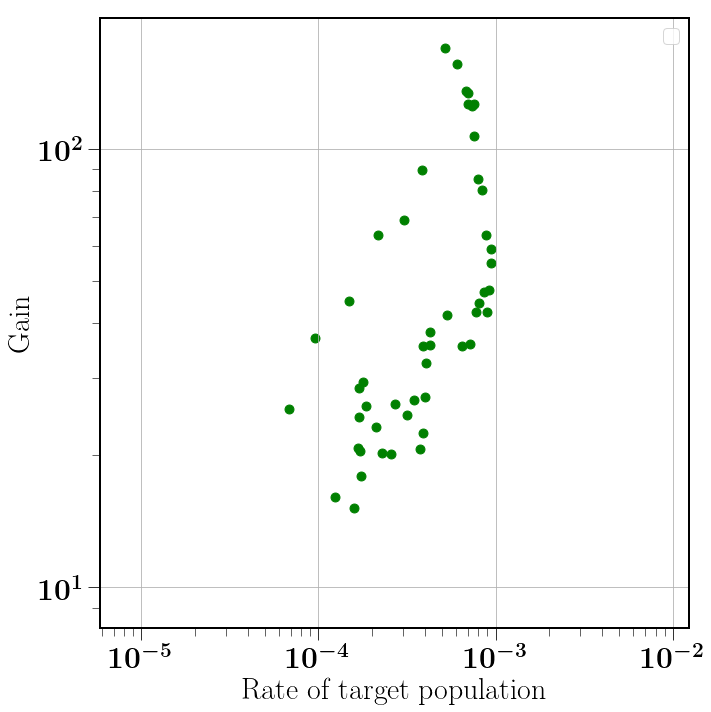

In [21]:
f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
    print(Rate)
    ax.scatter(Rate, Gain, s=80, color='g')
    
    if ZZ ==0.001:
       ax.scatter(Rate, 39, s=80, color='r', label="STROOPWAFEL 2019 paper") 
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rate of target population', fontsize=30)
ax.set_ylabel('Gain', fontsize=30)
ax.legend(fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=30)


f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_LOG_new.png', bbox_inches='tight')
plt.show()

53.046600000000005


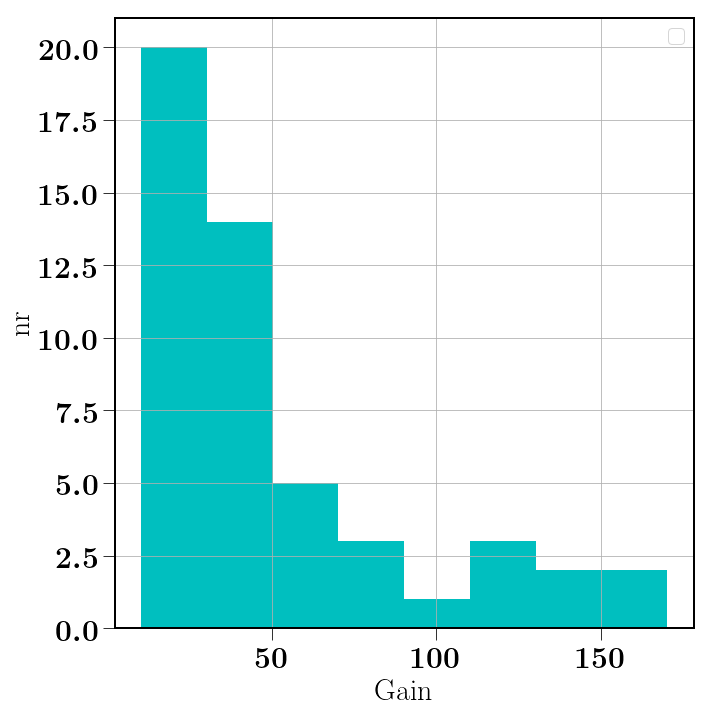

In [20]:
array_gains = []


f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems

for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
    array_gains.append(Gain)
    
ax.hist(array_gains, 8, color='c')

ax.set_ylabel('nr', fontsize=30)
ax.set_xlabel('Gain', fontsize=30)
ax.legend(fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=30)

print(np.mean(array_gains))
f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_hist_new.png', bbox_inches='tight')
plt.show()

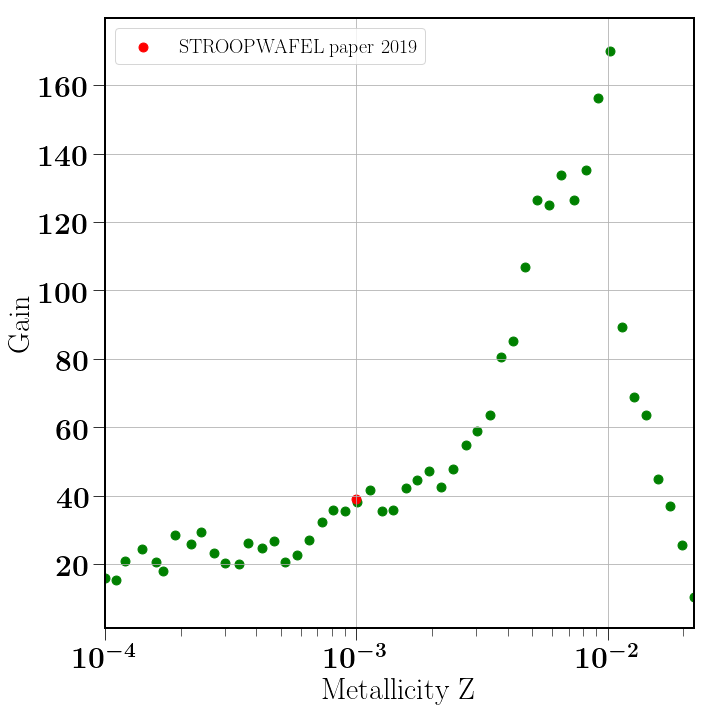

In [22]:
f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[1.5]})

DATAmetallicities = Data.metallicitySystems
ax.grid(True)
ax.tick_params(labelsize=30)


for ZZ in set(DATAmetallicities):
#     print('at ', ZZ)
#     print()
    maskZZ = DATAmetallicities ==ZZ
#     print('at Z=', ZZ, 'the gain =', np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),1), 'x')
    
    Rate = np.sum(Data.weight[maskZZ]) / 1E6
    Gain = np.round(len((Data.weight[maskZZ]))/np.sum(Data.weight[maskZZ]),2)
#     print(Rate)
    ax.scatter(ZZ, Gain, s=80, color='g')
    
#     if ZZ ==0.001:
#        ax.scatter(ZZ, Gain, s=80, color='r') 
ax.set_xlim(min(DATAmetallicities), max(DATAmetallicities))    
# ax.plot([min(DATAmetallicities), max(DATAmetallicities)], [40,40], c='k', linestyle=':', lw=5, label='STROOPWAFEL paper 2019')
ax.scatter([0.001], [39], c='r',  s=80, label='STROOPWAFEL paper 2019')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Metallicity Z', fontsize=30)
ax.set_ylabel('Gain', fontsize=30)



lgd = ax.legend(fontsize=20)



f.tight_layout()
f.savefig('./BHNS_STROOPWAFEL_gain_Z_new.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# path = '/Volumes/TOSHIBA EXT/black_hole-neutron_star/' + 'Fiducial/'

# #specific path to use now
# path1 = path+'COMPASOutput.h5'
# f_file = h5.File(path1)
# fDCO=f_file['doubleCompactObjects']
# DCOmask = maskTargetDCOsSTROOPWAFEL(DCOtype='BHNS', boolDCOmask=[1,1,1], f=f_file, otherSelection=None, otherparam=None)

In [ ]:
# colorlist = ['', '', '' , '', '', '', '', '']
# colorlist[7] = 'gray'

# for nrC in range(7):
#     if (nrC>=0) & (nrC<=3):
#         cm       = plt.get_cmap('plasma')
#         indd = nrC+1

#         mycolors = [cm(x) for x in np.linspace(0,1 , (5))] 
#         colorlist[nrC] = mycolors[indd] 

# #     if nrC==5:
# #         colorlist[nrC]='lightblue'


#     if (nrC>=4) & (nrC<=6):
#         cm       = plt.get_cmap('viridis_r')
#         indd = nrC-3
#         mycolors = [cm(x) for x in np.linspace(0,1 , (5))] 
#         colorlist[nrC] = mycolors[indd] 

# #     if nrC==6:
# #         colorlist[nrC]='green'
        
        
# dictChannelsBHNSListBolt = [r'\textbf{case A}', r'\textbf{case B}',  r'\textbf{case C}',\
#                             r'\textbf{case B only stable}',\
#                             r'\textbf{case B immediate CE}',
#                             r'\textbf{case C immediate} \textbf{CE}',\
#                              r'\textbf{double-core CE}', r'\textbf{other}']

# Make Population 2D plots

In [ ]:
# ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# # weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


# def plotInitialMasses(ax, fc, Data, dictRank, dictList, channelLabelList, withinHubble=True):
#     """
#     ## parameters: 
#     ax: axes to plot on
#     fc: formationchannels function 
#     Data: Data with the target binary already specified
#     dictRank: dictionary of the channels & their channel nr for all metallicities
#     dictList: List with the names of the channels
#     channelLabelList # hack for which labels to give in legend
#     withinHubble: whether to select only DCOs that merge in a Hubble time
#     """
#     maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
#     for z_ind, chosenMetallicity in enumerate(metallicities):
#         print('now at Z = %s'%chosenMetallicity)
# #         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
#         solar = 0.0142
#         log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
#         for nrC, Channel in enumerate(dictList):
#             #Get the seeds that relate to sorted indices
#             seedsInterest = []
# #             Channel_nr = Channel-1
#             for index in dictRank[Channel]:
#                 seedsInterest.extend(fc.sortedSeeds[index-1])
            

            
#             #Get metallicity systems this works because seeds in both
#             #files are in the same order
#             mask = np.in1d(Data.seeds, np.array(seedsInterest))
#             if withinHubble == True:
#                 mask = mask & (Data.Hubble == True)
#             DATAmetallicities = Data.metallicitySystems[mask]
#             maskZ = (DATAmetallicities==chosenMetallicity)
 
#             M1ZAMS = Data.m1zams[mask][maskZ]
#             M2ZAMS = Data.m2zams[mask][maskZ]
#             weights= Data.weight[mask][maskZ]
            
  
            
#             if z_ind==0: # only legendlabel in one of 2 metallicity plots

#                 legendlabel=Channel
#             else:
#                 legendlabel=None
#             ax[z_ind].scatter(np.log10(M1ZAMS),np.log10(M2ZAMS),s=weights*stimes_weight, linewidth=0.1, \
#                               c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])

#             if list(M1ZAMS):
#                 maxM2ZAMSOLD = max(maxM2ZAMSOLD, np.max(M2ZAMS))
#                 maxM1ZAMSOLD = max(maxM1ZAMSOLD, np.max(M1ZAMS))
#                 print( len(M1ZAMS), '= # BHNS')
       
     
#         if z_ind==0:
            
#             ax[z_ind].set_ylabel(ylabel, fontsize=fs)
# #             ax[z_ind].tick_params(which='both', width=2)
            
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
#         ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
#         ax[z_ind].tick_params(labelsize=fs)
# #         ax[z_ind].grid(True, which='major');

#         ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        

        
#         ax[z_ind].set_xlim(np.log10(10), np.log10(150))
#         ax[z_ind].set_ylim(np.log10(9), np.log10(40))  

        
        
# #         ax2 = ax[z_ind].twiny()
# #         ax2y = ax[z_ind].twinx()
        

#         ax[z_ind].tick_params(labelsize=fs)
# #         ax2.set_xlabel(xlabel2, fontsize=fs)

#         ax[z_ind].set_ylim(np.log10(10), np.log10(40)) 
        

#         ycord_line = np.linspace(-2,3,100)
#         # plot a few coordinates:
#         xcordlist = [20,50,100]
#         for ind_cord, xcord in enumerate(xcordlist):
#             xcord_line = np.log10(xcord) * np.ones_like(ycord_line)
#             ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
#             ax[z_ind].text(np.log10(xcord), 1.6, s=r'%s $\rm{M}_{\odot}$'%xcord, fontsize=14, \
#                            horizontalalignment='right', verticalalignment='top', rotation=90)   
        

#         xcord_line = np.linspace(-2,3,100)
#         # plot a few coordinates:
#         ycordlist = [15,25]
#         for ind_cord, ycord in enumerate(ycordlist):
#             ycord_line = np.log10(ycord) * np.ones_like(xcord_line)
#             ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
#             ax[z_ind].text(1.01, np.log10(ycord), s=r' %s $\rm{AU}$'%ycord, fontsize=14, \
#                            horizontalalignment='left', verticalalignment='bottom', rotation=0)         
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.85),\
#                            xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
              
        
#         if z_ind ==0:    
#             handles, labels = ax[z_ind].get_legend_handles_labels()
    
    
#     return handles, labels




In [ ]:


f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
# xlabel2 = r'\textbf{initial mass} $m_{1} \, [\rm{M}_{\odot}]$'
# ylabel2 = r'\textbf{initial mass} $m_{2} \, [\rm{M}_{\odot}]$'

xlabel = r'\textbf{initial mass} $\log_{10}(m_{1,{\rm{i}}}) \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{initial mass} $\log_{10}(m_{2,{\rm{i}}}) \, [\rm{M}_{\odot}]$'


handles, labels = plotInitialMasses(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList,channelLabelList=range(8), withinHubble=True)

lgd = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.86, 1.12),  markerscale=3., scatterpoints=1) # loc = 'upper center')




f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)


markersize_lgd = 200
lgd.legendHandles[0]._sizes = [markersize_lgd]
lgd.legendHandles[1]._sizes = [markersize_lgd]
lgd.legendHandles[2]._sizes = [markersize_lgd]
lgd.legendHandles[3]._sizes = [markersize_lgd]
lgd.legendHandles[4]._sizes = [markersize_lgd]
# lgd.legendHandles[5]._sizes = [markersize_lgd]
# lgd.legendHandles[6]._sizes = [markersize_lgd]
# lgd.legendHandles[7]._sizes = [markersize_lgd]

# f.tight_layout()
f.savefig('./BHNS_ZAMSmasses_channels_combined_pessimistic_4channels.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()        






# OBTAIN SEEDS FOR DETAILED EVOLUTION

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def obtainSeeds(fc, Data, dictRank, dictList, withinHubble=True, Z=0.001):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate([Z]):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            print('at channel',Channel)
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
#                 print(dictRank[Channel], 'dictRank')
                seedsInterest.extend(fc.sortedSeeds[index-1])
            

                #Get metallicity systems this works because seeds in both
                #files are in the same order
                mask = np.in1d(Data.seeds, np.array(seedsInterest))
                if withinHubble == True:
                    mask = mask & (Data.Hubble == True)
                DATAmetallicities = Data.metallicitySystems[mask]
    #             print DATAmetallicities
                maskZ = (DATAmetallicities==chosenMetallicity)

    #             weights = Data.weight[mask] # //floor weights    
                M1ZAMS = Data.m1zams[mask][maskZ]
                M2ZAMS = Data.m2zams[mask][maskZ]
                weights= Data.weight[mask][maskZ]
                
                if Z==0.0142:
                    indZ=26
                    SeedPlus = int(100000000000 * indZ)
                if Z==0.001:
                    indZ=5
                    SeedPlus = int(100000000000 * indZ)

                
                if len(weights):
                    print(index,':', ', ', (np.asarray(seedsInterest)[maskZ][0])-SeedPlus)

    #             print(M1ZAMS[0:5])
    #             print(DATAmetallicities[maskZ])

                if z_ind==0: # only legendlabel in one of 2 metallicity plots
                    legendlabel=Channel
                else:
                    legendlabel=None
                    
                seedsInterest = []



            
            

    
    return 



obtainSeeds(fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True, Z=0.001)


# Both final masses 

In [ ]:
# ### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# # weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


# def plotfinalmasses(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH=None):
#     """
#     ## parameters: 
#     ax: axes to plot on
#     fc: formationchannels function 
#     Data: Data with the target binary already specified
#     dictRank: dictionary of the channels & their channel nr for all metallicities
#     dictList: List with the names of the channels
#     withinHubble: whether to select only DCOs that merge in a Hubble time
#     """
    
    
#     maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
#     for z_ind, chosenMetallicity in enumerate(metallicities):
        
#         rateq3 =0
#         rateq5 = 0
#         rateALL = 0
#         print('now at Z = %s'%chosenMetallicity)
# #         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
#         solar = 0.0142
#         log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

#         xx = np.linspace(1,25,1000)
#         yy0_3 = xx*0.3     
#         if z_ind ==0:
#             labelqlegend=None
#         else:
#             labelqlegend=r'$q_{\rm{final}}\leq 3$'
            
#         ax[z_ind].fill_between(x=xx,y1=np.ones_like(xx)*2.5, y2=yy0_3,where= yy0_3<=2.5,\
#                                 color='gray', label=labelqlegend, alpha =0.3,hatch='/')
#         ax[z_ind].plot(xx,yy0_3, lw = 2, color='k', linestyle=':' )
# #         ax[z_ind].fill_between(x=xx,y1=np.zeros_like(xx), y2=yy0_3,\
# #                                 color='gray', label=None, alpha =0.3)
                    
#         for nrC, Channel in enumerate(dictList):
#             #Get the seeds that relate to sorted indices
#             seedsInterest = []
# #             Channel_nr = Channel-1
#             for index in dictRank[Channel]:
#                 seedsInterest.extend(fc.sortedSeeds[index-1])
#             #Get metallicity systems this works because seeds in both
#             #files are in the same order
#             mask = np.in1d(Data.seeds, np.array(seedsInterest))
#             if withinHubble == True:
#                 mask = mask & (Data.Hubble == True)
#             DATAmetallicities = Data.metallicitySystems[mask]
#             maskZ = (DATAmetallicities==chosenMetallicity)

#             weightsALL = Data.weight[mask][maskZ].squeeze() # //floor weights    
#             M1 = Data.mass1[mask][maskZ]
#             M2 = Data.mass2[mask][maskZ]
            
#             maskBHNS = getMaskBHNS(m1bh=M1, m2bh=M2)
# #             if BHNSorNSBH =='BHNS':
#             maskBHNS = maskBHNS
#             maskNSBH = ~maskBHNS
# #             else:
# #                 maskBHNSorNSBH = ~maskBHNS # opposite
            
#             weightsBHNS= Data.weight[mask][maskZ][maskBHNS]
#             M1BHNS = M1[maskBHNS]
#             M2BHNS = M2[maskBHNS]
#             weightsNSBH= Data.weight[mask][maskZ][maskNSBH]
#             M1NSBH = M1[maskNSBH]
#             M2NSBH = M2[maskNSBH]

            
            
            
#             maskq3=np.zeros_like(M1)
#             maskq5=np.zeros_like(M1)
# #             print(np.shape(maskq3), np.shape(maskBHNS),np.shape((M1BHNS/M2NSBH <=3)), 'hello')
#             maskq3[maskBHNS] = (M1BHNS/M2BHNS <=3.) 
#             maskq3[maskNSBH] = (M2NSBH/M1NSBH <=3.)
#             maskq5[maskBHNS] = (M1BHNS/M2BHNS <=5.) 
#             maskq5[maskNSBH] = (M2NSBH/M1NSBH <=5.)
            
# #             print(maskq3==True)
            
            
#             rateq3+=np.sum(weightsALL[maskq3==True])
#             rateq5+=np.sum(weightsALL[maskq5==True])
#             rateALL+=np.sum(weightsALL)
            
#             if z_ind==0: # only legendlabel in one of 2 metallicity plots
#                 legendlabel=Channel
#             else:
#                 legendlabel=None

            
# #             if BHNSorNSBH=='BHNS':
#             ax[z_ind].scatter(M1BHNS, M2BHNS,s=weightsBHNS*stimes_weight, edgecolor ='', linewidth=0.1,\
#              c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
# #                 ax[z_ind].scatter(M1, M2, c=colorlist[nrC],\
# #                                   s=20, edgecolor = 'k', label =legendlabel,\
# #                                  linewidth='0.2')
                
# #                 massRatio = M2/M1 
                
                
                
# #             else:
                
#             ax[z_ind].scatter(M2NSBH, M1NSBH,s=
#                               weightsNSBH*stimes_weight, edgecolor ='k', linewidth=0.1,\
#              c=colorlist[nrC],label=None, zorder=zorderlist[Channel])
# #                 ax[z_ind].scatter(M2, M1, c=colorlist[nrC],\
# #                                   s=20, edgecolor = 'k', label =None,\
# #                                  linewidth='0.2')                

            
#         if z_ind==0:
            
#             ax[z_ind].set_ylabel(ylabel, fontsize=fs)
# #             ax[z_ind].tick_params(which='both', width=2)
            
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
#         ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
#         ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

#         ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
#         ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props, zorder=100)
# #         ax[z_ind].annotate(r'\textbf{%s}'%BHNSorNSBH, xy=(0.6, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)


        
        
#         if z_ind ==1:    
            
# #             if BHNSorNSBH=='BHNS':
#             ax[z_ind].set_xlim(1.8, 12.5)
#             ax[z_ind].set_ylim(1.2, 2.5)
#             ax[z_ind].legend(fontsize=fs-5, loc='lower right')
#         if z_ind ==0:    
            
#             handles, labels = ax[z_ind].get_legend_handles_labels()    
#             ax[z_ind].set_xlim(1.8, 40)
#             ax[z_ind].set_ylim(1.2, 2.5)
            
#         print('for Z=',chosenMetallicity, 'we find rates with q <= 3 (5) of ', rateq3/rateALL, '(',rateq5/rateALL,')')
#     return handles, labels






In [ ]:
# h

# ONLY NSBH



In [ ]:
print( np.asarray([1]))

In [ ]:
### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotBHNSfinal(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH= 'BHNS'):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

        xx = np.linspace(1,25,1000)
        yy0_3 = xx*0.3     
        if z_ind ==0:
            labelqlegend=None
        else:
            labelqlegend=r'$q_{\rm{final}}\geq 3$'
            
        ax[z_ind].fill_between(x=xx,y1=np.ones_like(xx)*2.5, y2=yy0_3,where= yy0_3<=2.5,\
                                color='gray', label=labelqlegend, alpha =0.3,hatch='/')
        ax[z_ind].plot(xx,yy0_3, lw = 2, color='k', linestyle=':' )
#         ax[z_ind].fill_between(x=xx,y1=np.zeros_like(xx), y2=yy0_3,\
#                                 color='gray', label=None, alpha =0.3)
                    
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1 = Data.mass1[mask][maskZ]
            M2 = Data.mass2[mask][maskZ]
            
            maskBHNS = getMaskBHNS(m1bh=M1, m2bh=M2)
            if BHNSorNSBH =='BHNS':
                maskBHNSorNSBH = maskBHNS
            else:
                maskBHNSorNSBH = ~maskBHNS # opposite
            
            weights= Data.weight[mask][maskZ][maskBHNSorNSBH]
            M1 = M1[maskBHNSorNSBH]
            M2 = M2[maskBHNSorNSBH]


        
            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=Channel
            else:
                legendlabel=None

            
            if BHNSorNSBH=='BHNS':
                ax[z_ind].scatter(M1, M2,s=weights*stimes_weight, edgecolor ='k', linewidth=0.1,\
                 c=colorlist[nrC],label =legendlabel)
#                 ax[z_ind].scatter(M1, M2, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =legendlabel,\
#                                  linewidth='0.2')
                
                massRatio = M2/M1 
                
                
                
            else:
                
                ax[z_ind].scatter(M2, M1,s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
                 c=colorlist[nrC],label=None)
#                 ax[z_ind].scatter(M2, M1, c=colorlist[nrC],\
#                                   s=20, edgecolor = 'k', label =None,\
#                                  linewidth='0.2')                

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
        ax[z_ind].annotate(r'\textbf{%s}'%BHNSorNSBH, xy=(0.6, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="bottom",bbox=bbox_props)


        
        

        
        
        
        if z_ind ==1:    
            ax[z_ind].legend(fontsize=fs-5, loc='lower right')
            if BHNSorNSBH=='BHNS':
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)            

        if z_ind ==0:    
            handles, labels = ax[z_ind].get_legend_handles_labels()    
            if BHNSorNSBH=='BHNS':
                ax[z_ind].set_xlim(2.5, 41)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.5, 15)
                ax[z_ind].set_ylim(1.2, 2.5)              
            
    return handles, labels





In [ ]:


# dictChannelsBHNStemp = { 'stable A':[10,16,19], 'case B immediate CE':[6,7,20,29],\
#                     'stable B':[25], 'stable B no CEE':[8,11,31,], \
#                     'stable C':[4,15,26],\
#                 r'case C immediate CE':[17,21],  r'double-core CE':[3,12,13,23,24,27,30],  \
#                     'other':[22, 32,33,34,35,36,37,38,39,40,41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]\
#                     }

# # # dictChannelsBHNStemp = 'stable B':[1,2,5,9,14,18,25,28]
# dictChannelsBHNSListtemp = ['stable B'] 

f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
ylabel = r'\textbf{final mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'
xlabel = r'\textbf{final mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'



handles, labels = plotBHNSfinal(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')


lgd = f.legend(handles, dictChannelsBHNSListBolt,\
         fontsize=20, ncol=4,\
         bbox_to_anchor=(.97, 1.1),   scatterpoints=1) # loc = 'upper center')

# lgd.legendHandles.legmarker.set_markersize(200)
# lgd.legendHandles[1]._legmarker.set_markersize(6)

markersize_lgd = 120
lgd.legendHandles[0]._sizes = [markersize_lgd]
lgd.legendHandles[1]._sizes = [markersize_lgd]
lgd.legendHandles[2]._sizes = [markersize_lgd]
lgd.legendHandles[3]._sizes = [markersize_lgd]
lgd.legendHandles[4]._sizes = [markersize_lgd]
lgd.legendHandles[5]._sizes = [markersize_lgd]
lgd.legendHandles[6]._sizes = [markersize_lgd]
lgd.legendHandles[7]._sizes = [markersize_lgd]

f.tight_layout()
f.savefig('./BHNS_DCOmasses_NSBH_combined_pessimistic.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()
plt.close()        


       






In [ ]:
f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


    
# colorlist = [, , ,  'deepskyblue', 'gold','#8c564b', 'gold'] # colours of channels 
ylabel = r'\textbf{final mass} $m_{\rm{NS}} \, [M_{\odot}]$'
xlabel = r'\textbf{final mass} $m_{\rm{BH}} \, [M_{\odot}]$'



_, _ = plotBHNSfinal(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='NSBH')




plt.tight_layout()
plt.savefig('./NSBH_DCOmasses_NSBH_combined_pessimistic.png')
plt.show()
plt.close()        







# separation and ZAMS mass

# plot q and Separation

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


# def plotInitialqVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
#     """
#     ## parameters: 
#     ax: axes to plot on
#     fc: formationchannels function 
#     Data: Data with the target binary already specified
#     dictRank: dictionary of the channels & their channel nr for all metallicities
#     dictList: List with the names of the channels
#     withinHubble: whether to select only DCOs that merge in a Hubble time
#     """
#     maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
#     for z_ind, chosenMetallicity in enumerate(metallicities):
#         print('now at Z = %s'%chosenMetallicity)
# #         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
#         solar = 0.0142
#         log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
#         for nrC, Channel in enumerate(dictList):
#             #Get the seeds that relate to sorted indices
#             seedsInterest = []
# #             Channel_nr = Channel-1
#             for index in dictRank[Channel]:
#                 seedsInterest.extend(fc.sortedSeeds[index-1])
#             #Get metallicity systems this works because seeds in both
#             #files are in the same order
#             mask = np.in1d(Data.seeds, np.array(seedsInterest))
#             if withinHubble == True:
#                 mask = mask & (Data.Hubble == True)
#             DATAmetallicities = Data.metallicitySystems[mask]
# #             print DATAmetallicities
#             maskZ = (DATAmetallicities==chosenMetallicity)

# #             weights = Data.weight[mask] # //floor weights    
#             M1ZAMS = Data.m1zams[mask][maskZ]
#             M2ZAMS = Data.m2zams[mask][maskZ]
#             separationInitial = Data.separationzams[mask][maskZ]
#             separationInitial = np.log10(separationInitial)
#             qZAMS = M2ZAMS /M1ZAMS
#             weights= Data.weight[mask][maskZ]
# #             print(DATAmetallicities[maskZ])

        
# #             print(DATAmetallicities[maskZ])

#             if z_ind==0: # only legendlabel in one of 2 metallicity plots
#                 legendlabel=None
#             else:
#                 legendlabel=None
            

#             if len(weights):

#                 ax[z_ind].scatter(qZAMS,separationInitial,s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
#                                  c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
                                  

            
#         if z_ind==0:
            
#             ax[z_ind].set_ylabel(ylabel, fontsize=fs)
# #             ax[z_ind].tick_params(which='both', width=2)
            
# #         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
#         ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
#         ax[z_ind].tick_params(labelsize=fs)
# #         ax[z_ind].grid(True, which='major');

#         ax[z_ind].set_xlabel(xlabel, fontsize=fs)


# #         ax[z_ind].grid(True)
#         ax[z_ind].set_xlim(0, 1)
#         ax[z_ind].set_ylim(-1.1, 2) 


        
# #         ### 2nd axes###
# #         ax2y = ax[z_ind].twinx()
        
# #         ax2y.set_xlim(0,1)
# #         ax2y.set_ylim(-1.1, 2) 
# # #         ax2y.set_yscale('log')
# #         ax2y.tick_params(labelsize=fs)
# #         if z_ind==1:
# #             ax2y.set_ylabel(ylabel2, fontsize=fs)           
                
        

# #         ax2y.set_yticks([np.log10(0.5),np.log10(5),np.log10(50)])
# #         ax2y.set_yticklabels( [r'$0.5$',r'$5$', r'$50$'] )#[        

# #         ##################
        
        
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())


#         xcord_line = np.linspace(-2,3,100)
#         # plot a few coordinates:
#         ycordlist = [0.5, 5, 50]
#         for ind_cord, ycord in enumerate(ycordlist):
#             ycord_line = np.log10(ycord) * np.ones_like(xcord_line)
#             ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
#             ax[z_ind].text(0.02, np.log10(ycord), s=r' %s $\rm{AU}$'%ycord, fontsize=14, \
#                            horizontalalignment='left', verticalalignment='bottom', rotation=0)         
        
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.55, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
# #         if z_ind ==0:  
# #             handles, labels = ax[z_ind].get_legend_handles_labels()
            
            
    
#     return handles, labels



In [ ]:


xlabel = r'\textbf{initial mass ratio} $q_{\rm{i}} $'
ylabel2 = r'\textbf{initial separation} $a_{\rm{i}} \, [\rm{AU}]$'
ylabel = r'\textbf{initial separation} $\log_{10}(a_{\rm{i}}) \, [\rm{AU}]$'


f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})



f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

handles, labels = plotInitialqVSseparation(ax=ax, fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


# f.legend(handles, labels, fontsize=20, ncol=4,bbox_to_anchor=(.95, 1.1)) # loc = 'upper center')
plt.tight_layout()
plt.savefig('./BHNS_ZAMSqseparation_combined_pessimistic_4channels.png')
plt.show()
plt.close()        






# ----- START HERE -----

# Load data & process channels etc. 

In [11]:

# GENERAL DATA SETTINGS FOR PLOTS 

metallicities = [0.001, 0.0142]
metallicityLabels = ['Z=0.001', 'Z=0.0142']

#### Fiducial 
MODEL = 'Fiducial'




fc = FC.FormationChannels(path = pathCOMPASOutput)
fc.formationChannelsSeeds(types='BHNS', withinHubbleTime=True, optimistic=False)
#Based on previous notes I already now the ranks and channels


#But I want only within Hubble time 
Data            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types='BHNS',  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
SeedsHubble    = Data.seeds[Data.Hubble==True]


print(len(SeedsHubble))

print(np.sum(Data.weight), len((Data.weight)))



DATAmetallicities = Data.metallicitySystems


stimes_weight = 200




(23171.94883174836, 'sum sorted counts')
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
1525531
23171.948831748363 1525531


## COSMIC INTEGRATION 

In [12]:
import ClassCosmicIntegrator  as CI 

#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 100
Data_CI = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat', withinHubbleTime=True)






weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()


# A000: 

In [13]:
Data_CI.MSSFR.Zprescription         = 'logNormal' 
Data_CI.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
Data_CI.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'
Data_CI.MSSFR.GSMFprescription      = None
Data_CI.MSSFR.ZMprescription        = None
Data_CI.cosmologicalIntegration()
weightSTROOPWAFEL = Data_CI.COMPAS.weight # //floor weight
Row        =  np.sum(Data_CI.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
# 

rateIntrinsic = Data_CI.PerSystemPerRedshift_ratesIntrinsic[:,:] * Data_CI.COMPAS.weight
rateIntrinsic_zIntegrated = (np.sum(rateIntrinsic, axis=0))
ModelName = 'A000'

# A231

In [ ]:
Data_CI.MSSFR.Zprescription         = 'MZ_GSMF' 
Data_CI.MSSFR.SFRprescription       = 'Strolger et al. (2004)'
Data_CI.MSSFR.logNormalPrescription = None
Data_CI.MSSFR.GSMFprescription      = 'Furlong et al. (2015) Double'
Data_CI.MSSFR.ZMprescription        =  'Langer et al. (2006)'
Data_CI.cosmologicalIntegration()
weightSTROOPWAFEL = Data_CI.COMPAS.weight # //floor weight
Row        =  np.sum(Data_CI.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
# 

rateIntrinsic = Data_CI.PerSystemPerRedshift_ratesIntrinsic[:,:] * Data_CI.COMPAS.weight
rateIntrinsic_zIntegrated = (np.sum(rateIntrinsic, axis=0))
ModelName = 'A231'

# COMBINE INITIAL PROP PLOTS

## 1. initial masses and initial separation and mass ratio

In [14]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


    
import math

def plotInitialMasses(ax, fc, Data, dictRank, dictList, channelLabelList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    channelLabelList # hack for which labels to give in legend
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at z_ind = %s'%z_ind)
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            

            
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)

            # use the cosmic integrated weights if they exist - Coen Model
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight

            maskZlow = (DATAmetallicities <= 0.01)
            maskZhigh = (DATAmetallicities > 0.01)
            
            if z_ind==0:   
                M1ZAMS = Data.m1zams[mask][maskZlow]
                M2ZAMS = Data.m2zams[mask][maskZlow]
                weights= weight[mask][maskZlow]
            elif z_ind==1:
                M1ZAMS = Data.m1zams[mask][maskZhigh]
                M2ZAMS = Data.m2zams[mask][maskZhigh]
                weights= weight[mask][maskZhigh]
#             M1ZAMS = Data.m1zams[mask][maskZ]
#             M2ZAMS = Data.m2zams[mask][maskZ]
#             weights= Data.weight[mask][maskZ]
            
  
            
            if z_ind==0: # only legendlabel in one of 2 metallicity plots

                legendlabel=Channel
            else:
                legendlabel=None
            ax[z_ind].scatter((M1ZAMS),(M2ZAMS),s=weights*stimes_weight, linewidth=0.1, \
                              c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])

            if list(M1ZAMS):
                maxM2ZAMSOLD = max(maxM2ZAMSOLD, np.max(M2ZAMS))
                maxM1ZAMSOLD = max(maxM1ZAMSOLD, np.max(M1ZAMS))
                print( len(M1ZAMS), '= # BHNS')
       
     
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        xmin, xmax = 5,150
        ymin, ymax = 5,50
        ax[z_ind].set_xlim(xmin, xmax)
        ax[z_ind].set_ylim(ymin, ymax)  
        

        ax[z_ind].tick_params(labelsize=fs)

        
#         # ADD LINES
#         ycord_line = np.linspace(-2,3,100)
#         # plot a few coordinates:
#         xcordlist = [20,50,100]
#         for ind_cord, xcord in enumerate(xcordlist):
#             xcord_line = np.log10(xcord) * np.ones_like(ycord_line)
#             ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
#             ax[z_ind].text(np.log10(xcord), 1.6, s=r'%s $\rm{M}_{\odot}$'%xcord, fontsize=14, \
#                            horizontalalignment='right', verticalalignment='top', rotation=90)   



        ## Add constant mass  lines 
#         ycord_line = np.linspace(10**-2,10**3,100)
#         # plot a few coordinates:
#         xcordlist = [20,80,120]
#         for ind_cord, xcord in enumerate(xcordlist):
#             xcord_line = (xcord) * np.ones_like(ycord_line)
#             ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
#             ax[z_ind].text((xcord), 60, s=r'%s $\rm{M}_{\odot}$'%xcord, fontsize=14, \
#                            horizontalalignment='right', verticalalignment='top', rotation=90)   
        

        ## Add constant mass ratio lines 
        x_q = np.linspace(5,150) # Msun, M1 range
        # plot a few fixed mass ratios:
        qlist = [5., 3., 2., 1.]
        for ind_q, qvalue in enumerate(qlist):
            y_q =  x_q / qvalue
            
            
            y_text = 45. # Msun 
            if y_text*qvalue < 150:
                x_text = y_text * qvalue 
            else: 
                x_text = 141.
                y_text = x_text / qvalue
                
            # I am calculating the angle theta for the text: (see notes on this)
            delta_y = ((y_text - ymin) / (ymax-ymin)) 
            delta_x = ((x_text - xmin*qvalue) / (xmax-xmin))
            ratio = delta_y / delta_x
            theta_angle = math.degrees(math.atan((ratio)))

            ax[z_ind].plot(x_q, y_q, c='k', lw=2, linestyle =':')
            ax[z_ind].text(x_text, y_text, s=r'$q_{\rm{i}} =$ %s '%qvalue, fontsize=14, \
                           horizontalalignment='center', verticalalignment='bottom', rotation=theta_angle)   
                
        
        
    

        # PLOT metallicity labels 
        if z_ind==0:
            text_Z = 'low metallicities, '
        elif z_ind==1:
            text_Z = 'high metallicities, '

        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(r'%s $Z_{\rm{i}}  %s$'%(text_Z, metallicityLabels[z_ind]), xy=(0.5, 1.06), xycoords='axes fraction', fontsize = fs, weight = 'bold',ha='center', va="bottom",bbox=bbox_props)

        
        if z_ind ==0:    
            handles, labels = ax[z_ind].get_legend_handles_labels()
    
    
    return handles, labels




In [15]:


def plotInitialqVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    plots the initial mass ratio and separation for the binaries. 
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at z_ind = %s'%z_ind)

        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)
            
            # split in low and high metallicities
            maskZlow = (DATAmetallicities <= 0.01)
            maskZhigh = (DATAmetallicities > 0.01)

            
            # if wanted, use the cosmic integrated weights if they exist 
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight

            
            if z_ind==0:
                M1ZAMS = Data.m1zams[mask][maskZlow]
                M2ZAMS = Data.m2zams[mask][maskZlow]
                separationInitial = Data.separationzams[mask][maskZlow]
                weights= weight[mask][maskZlow] 
            elif z_ind==1:
                M1ZAMS = Data.m1zams[mask][maskZhigh]
                M2ZAMS = Data.m2zams[mask][maskZhigh]
                separationInitial = Data.separationzams[mask][maskZhigh]
                weights= weight[mask][maskZhigh]    
            separationInitial = np.log10(separationInitial)
            qZAMS = M2ZAMS /M1ZAMS
#             M1ZAMS = Data.m1zams[mask][maskZ]
#             M2ZAMS = Data.m2zams[mask][maskZ]
#             separationInitial = Data.separationzams[mask][maskZ]
#             separationInitial = np.log10(separationInitial)
#             qZAMS = M2ZAMS /M1ZAMS
#             weights= Data.weight[mask][maskZ]


            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=None
            else:
                legendlabel=None
            

            if len(weights):

                ax[z_ind].scatter(qZAMS,separationInitial,s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
                                  

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
#         ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)


#         ax[z_ind].grid(True)
        ax[z_ind].set_xlim(0, 1)
        ax[z_ind].set_ylim(-1.1, 2.3) 


        
#         ### 2nd axes###
#         ax2y = ax[z_ind].twinx()
        
#         ax2y.set_xlim(0,1)
#         ax2y.set_ylim(-1.1, 2) 
# #         ax2y.set_yscale('log')
#         ax2y.tick_params(labelsize=fs)
#         if z_ind==1:
#             ax2y.set_ylabel(ylabel2, fontsize=fs)           
                
        
#         ax2y.set_yticks([np.log10(0.5),np.log10(5),np.log10(50)])
#         ax2y.set_yticklabels( [r'$0.5$',r'$5$', r'$50$'] )#[        

#         ##################
        
        
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())

        # ADD separation lines
        xcord_line = np.linspace(-2,3,100)
        # plot a few coordinates:
        ycordlist = [0.5, 5, 50]
        for ind_cord, ycord in enumerate(ycordlist):
            ycord_line = np.log10(ycord) * np.ones_like(xcord_line)
            ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
            ax[z_ind].text(0.02, np.log10(ycord), s=r' %s $\rm{AU}$'%ycord, fontsize=14, \
                           horizontalalignment='left', verticalalignment='bottom', rotation=0)         
        
        if z_ind==0:
            text_Z = 'low metallicity \n '
        elif z_ind==1:
            text_Z = 'high metallicity \n'
        
        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(r'%s $Z_{\rm{i}}  %s$'%(text_Z, metallicityLabels[z_ind]), xy=(0.5, 1.08), xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='center', va="top",bbox=bbox_props)

        
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#         ax[z_ind].annotate(r'%s $Z_{\rm{i}}  %s$'%(text_Z, metallicityLabels[z_ind]), xy=(0.55, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
            
            
    
    return handles, labels


In [16]:
# dictChannelsBHNSListBolt = [r'\textbf{(I) Classic}', \
#                                 r'\textbf{(II) Only stable mass transfer}',\
#                                 r'\textbf{(III) Single-core CE as first mass transfer}',\
#                                  r'\textbf{(IV) Double-core CE as first mass transfer}', r'\textbf{other}']


-----------------
now doing initial masses
-----------------
now at z_ind = 0
871261 = # BHNS
434245 = # BHNS
36736 = # BHNS
3023 = # BHNS


IndexError: list index out of range

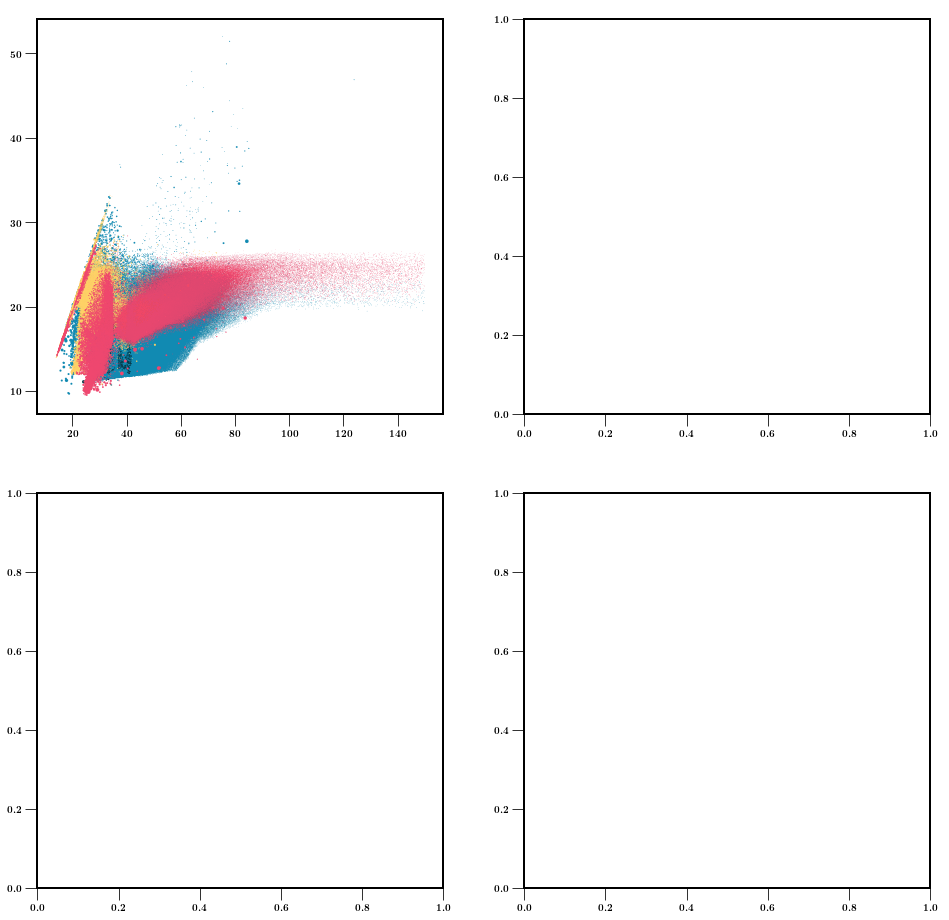

In [17]:

# Use MSSFR Integrated weights?
WeightsRateIntrinsic_zIntegrated=False
if WeightsRateIntrinsic_zIntegrated==False:
    ModelName = 'notMSSFRweighted'

stimes_weight = 7
metallicities = [0.0014,  0.01269]
metallicityLabels = ['\leq 0.01', '> 0.01']


print('-----------------')
print('now doing initial masses')
print('-----------------')

f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})




#### PLOT SEPARATION AND MASS RATIO ###
# xlabel = r'\textbf{initial mass} $\log(m_{1,{\rm{i}}}) \, [\rm{M}_{\odot}]$'
# ylabel = r'\textbf{initial mass} $\log(m_{2,{\rm{i}}}) \, [\rm{M}_{\odot}]$'
xlabel = r'\textbf{initial mass} $m_{1,{\rm{i}}} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{initial mass} $m_{2,{\rm{i}}} \, [\rm{M}_{\odot}]$'


PlotText = True

handles, labels = plotInitialMasses(ax=ax[0], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList,channelLabelList=range(8), withinHubble=True)

lgd2 = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.99, 1.13),  markerscale=3., scatterpoints=1) # loc = 'upper center')






markersize_lgd = 200
lgd2.legendHandles[0]._sizes = [markersize_lgd]
lgd2.legendHandles[1]._sizes = [markersize_lgd]
lgd2.legendHandles[2]._sizes = [markersize_lgd]
lgd2.legendHandles[3]._sizes = [markersize_lgd]
lgd2.legendHandles[4]._sizes = [markersize_lgd]



xlabel = r'\textbf{initial mass ratio} $1/q_{\rm{i}} $'
ylabel2 = r'\textbf{initial separation} $a_{\rm{i}} \, [\rm{AU}]$'
# ylabel = r'\textbf{initial separation} $\log_{10}(a_{\rm{i}}) \, [\rm{AU}]$'
ylabel = r'\textbf{initial semi-major axis} $\log(a_{\rm{i}}) \, [\rm{AU}]$'

print('-----------------')
print('now doing q vs separation')
print('-----------------')

# f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)
PlotText = False
handles, labels = plotInitialqVSseparation(ax=ax[1], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)






f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5) 
f.savefig('./BHNS_InitialParamBugFix_'+ ModelName + '.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi = 600)
plt.show()
plt.close()        



## 2. eccentricity and semi major axis at DCO formation

# Peters merger time calculation

In [ ]:
def timeToCoalescenceUsingInterpolation( a0,  e0,  m1,  m2):
    """/*
     Calculate the time to coalescence for a binary with arbitrary eccentricity using interpolation
     
     This is Equation 5.14 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224

     Parameters
     -----------
     a0 : 
        Initial semi-major axis in SI units
     e0 : 
        Initial eccentricity
     m1 :  
        Primary mass in SI units
     m2 : 
        Secondary mass in SI units
     
     Returns
     --------
     t_coalesce : 
        Time to coalescence in SI units (s)

     */
    """
    # Declare some variables
    tc       = 0.0;                                          # Time for a circular binary to coalesce
    beta     = 0.0;                                          # Beta constant (function of masses)
    tovertc  = 0.0;                                          # Result of interpolation of t/tc function
    

    # Calculate circular time to coalescence
    beta = calculateBeta(m1, m2);                                   # Masses should be in SI
    tc = a0*a0*a0*a0/(4.0*beta);                                    # Calculate time for a circular binary to merge
    
    # calculate t/tc using the interpolated function
    #tovertc = polynomialFitToToverTc(e0);                           # Ratio of inspiral time to that of circular system
    if((e0==0.0)or(e0==0)):
		return	tc;

    c0=a0*(1.0-e0*e0)*np.power(e0,-12.0/19.0)*np.power(1.0+(121.0*e0*e0/304.0), -870.0/2299.0);
		
		
    if(e0<0.01): 
		return c0*c0*c0*c0*np.power(e0,48.0/19.0)/(4.0*beta);
    

    if(e0>0.99):
		# Approximation of eq. 5.14 of Peters 1964, for high eccentricities
		return (768.0/425.0)*tc*np.power((1.0-(e0*e0)),3.5);
    	
    # otherwise: numerically integrate
    summ=0;
    de=e0/10000;
    e=0
    while(e<e0):
        summ=summ+de*np.power(e,29.0/19.0)*np.power((1.0+(121.0/304.0)*e*e),1181.0/2299.0)/np.power((1-e*e),1.5);
        e=e+de

    return 12.0/19.0*c0*c0*c0*c0/beta*summ;



def calculateBeta( m1,  m2):
    """/*
     # Calculate the constant beta based on masses as defined in Equation 5.9 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224
     
     Parameters
     -----------
     m1 : float
        Primary mass in SI units
     m2 : float
        Secondary mass in SI units
     
     Returns
     --------
     beta : float
        Mass parameter beta
 
     */
     """
    M = m1 + m2;

    return (64.0/5.0)*G*G*G*m1*m2*M*np.power(c,-5.0);



In [ ]:
from astropy import units as u
from astropy import constants as const
a =10**(2)*u.R_sun
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun

c= const.c.si
G = const.G.si

print(a)

time_x = (timeToCoalescenceUsingInterpolation(a0=a.to(u.meter), e0=0.96, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year))
print(time_x)
print(time_x.to(u.Gyr))

In [ ]:
def create_adaptive_separationArray(xstart,xend, Niter_a1, Niter_a2, Niter_a3):

    x_sep1 = np.logspace(-1.1, xstart, Niter_a1)
    x_sep2 = np.logspace(xstart*1.0001, xend, Niter_a2)
    x_sep3 = np.logspace(xend*1.0001, 3, Niter_a3)

    
    x_separation = np.concatenate((x_sep1, x_sep2))
    x_separation = np.concatenate((x_separation, x_sep3))
    
    x_separation = x_separation*u.R_sun # array of separations to try
    
    return x_separation
    




def obtain_a_and_e_for_fixed_mergerTime(x_separation, fixed_Tinsp, Niter_a, Niter_e):
    """ 
    
    fixed_Tinsp = wanted merger time in yrs
    
    """
    # constants
    M1 = 10*u.M_sun
    M2 = 1.4*u.M_sun
    c= const.c.si
    G = const.G.si
    ##
    if x_separation==None:
        x_separation = np.logspace(-1, 3, Niter_a)*u.R_sun # array of separations to try
    x_eccentricities = [] # list where we will append the solution of the eccentricities 

    emin =0
    for ind_a, sep in enumerate(x_separation):
        
        if ind_a%10==9:
            print('at iteration  ',ind_a+1 , ' of ', len(x_separation) )
        else:
            pass # do nothing and continue
        
        for ind_e, ecc in enumerate(np.linspace(emin, 1, Niter_e)):
#             solve_a = solve_a
            mergertime = timeToCoalescenceUsingInterpolation(a0=sep.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year) # in years
            if (mergertime <= fixed_Tinsp) | (ecc==1):
                x_eccentricities.append(ecc)
                emin = ecc
#                 print(emin, sep, ' = e, a')
                break 
    
    return x_eccentricities



Niter_a, Niter_e = 20,20
t_Hubble = 13.7*u.Gyr
t_Hubble_inyears = (t_Hubble.to(u.year))
req_times_list_names = ['thousandYr' ,'oneMyr', 'oneGyr', 'tHubble' ]

for ind_n, name_t in enumerate(req_times_list_names):

    TIME=name_t #'oneMyr'#'thousandYr'  #'tHubble'  #'tenMyr' #

    DEFAULT=False
    if DEFAULT==True:
        t_requested =  (1e6*u.year).to(u.year) #t_Hubble_inyears #(10*u.Myr).to(u.year) # in years
        
        
    if DEFAULT==True:
        x_separation = np.logspace(-1, 3, Niter_a)*u.R_sun # array of separations to try
        x_eccentricities = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=20)




    else:
        if TIME=='tHubble':
            xstart, xend = 0.8, 1.8
            x_separation_tHubble = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tHubble

            x_eccentricities_tHubble = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_Hubble_inyears, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tHubble

        elif TIME=='oneGyr':
            t_requested = (1*u.Gyr).to(u.year)
            xstart, xend = np.log10(4), np.log10(50)


            x_separation_tGyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tGyr

            x_eccentricities_tGyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tGyr

        elif TIME=='tenMyr':
            t_requested = (10*u.Myr).to(u.year)
            xstart, xend = np.log10(1), np.log10(20)


            x_separation_tTenMyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tTenMyr

            x_eccentricities_tTenMyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tTenMyr        


        elif TIME=='oneMyr':
            t_requested = (1*u.Myr).to(u.year)
            xstart, xend = np.log10(.6), np.log10(4)


            x_separation_toneMyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_toneMyr

            x_eccentricities_toneMyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_toneMyr  



        elif TIME=='thousandYr':
            t_requested = (1000*u.year).to(u.year)
            xstart, xend = np.log10(.101), np.log10(.6)


            x_separation_thousandYr  = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_thousandYr 

            x_eccentricities_thousandYr  = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_thousandYr        


        else:
            print('error time not known')





    f, ax= plt.subplots(ncols=1,figsize=(10,10), 
                      gridspec_kw={"width_ratios":[1.5]})

    ax.plot(x_separation, x_eccentricities)

    ax.scatter(x_separation, x_eccentricities, s=200, color='r')
    ax.set_xscale('log')
    plt.grid(True)
    plt.show()

# 2. Eccenttricity & Separation plot

In [ ]:


# # # case BB channel B : 2,14,18,25,28
# # # case BB channel C: 4,
# xlabel = r' \textbf{post SN2 separation} $(a) \, [\rm{R}_{\odot}]$' #\rm{R}_{\odot}
# ylabel = r'\textbf{post SN2 eccentricity} '
# xlabel2 = r' \textbf{post SN2 separation} $\log_{10}(a) \, [\rm{R}_{\odot}]$'

# f, ax= plt.subplots(ncols=2,figsize=(16,8), 
#                   gridspec_kw={"width_ratios":[1.5, 1.5]})




# _,_ = ploteVSseparation(ax=ax, fc=fc, Data=Data\
#                   , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


# # f.legend(handles, labels, fontsize=20, ncol=4,bbox_to_anchor=(.95, 1.1)) # loc = 'upper center')
# plt.tight_layout()
# # plt.savefig('./BHNS_DCOseparationeccentricity_combined_pessimistic_4channels.png')
# plt.show()
# plt.close()        







In [ ]:
H0                         = 67.8;         #                          // Hubble's Constant in km s^-1 Mpc^-1  (from plank approx 67.80±0.77) CPLB: Use WMAP value
H0SI                       = (H0*1000/3E22) *u.meter / (u.second*u.meter) ; 
Htime = 1/H0SI 
HubbleTime = Htime.to(u.year)

print(Htime.to(u.year))
print(np.log10(solvetime_a/u.R_sun))

# COMBINED FINAL PROPERTIES PLOTS:

In [ ]:
from astropy import units as u
from astropy import constants as const


def convert_a_to_P_circular(separation, M1, M2):
    """calculate Period from separation
    separation is separation (needs to be given in astropy units)
    M1 and M2 are masses of the binary
    
    """
    G = const.G # [gr cm s^2]
    

    mu = G*(M1+M2)
    period = 2*np.pi * np.sqrt(separation**3/mu)
    
    
    
    return period


Period = convert_a_to_P_circular(separation=1*u.Rsun, M1=1*u.Msun, M2=1*u.Msun)

print(Period.to(u.d))

In [ ]:



''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    
AUtoRsun = 214.939

def ploteVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """

    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    
    
#     print('is this 0?', weight_fast_mergers)
    for z_ind, chosenMetallicity in enumerate(metallicities):
        weight_fast_mergers, weight_all = 0,0 
        weight_fast_mergers_10, weight_fast_mergers_0_1 = 0,0
        print('now at Z = %s'%chosenMetallicity) 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            
            maskZ = (DATAmetallicities==chosenMetallicity)

            
            maskZlow = (DATAmetallicities <= 0.01)
            maskZhigh = (DATAmetallicities > 0.01)

            
            # use the cosmic integrated weights if they exist - Coen Model
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight
#             weight = Data.weight
            
            if z_ind==0:
                M1ZAMS = Data.m1zams[mask][maskZlow]
                M2ZAMS = Data.m2zams[mask][maskZlow]
                eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZlow]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZlow]
                M1 = Data.mass1[mask][maskZlow]
                M2 = Data.mass2[mask][maskZlow]    
                separationInitial = Data.separationzams[mask][maskZlow]
                weights= weight[mask][maskZlow] 
            elif z_ind==1:
                M1ZAMS = Data.m1zams[mask][maskZhigh]
                M2ZAMS = Data.m2zams[mask][maskZhigh]
                eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZhigh]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZhigh]
                M1 = Data.mass1[mask][maskZhigh]
                M2 = Data.mass2[mask][maskZhigh]   
                weights= weight[mask][maskZhigh] 
  
            qZAMS = M2ZAMS /M1ZAMS
#             eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZ]
#             separationDCOFormation=Data.separationDCOFormation[mask][maskZ]           
            
#             M1ZAMS = Data.m1zams[mask][maskZ]
#             M2ZAMS = Data.m2zams[mask][maskZ]
#             M1 = Data.mass1[mask][maskZ]
#             M2 = Data.mass2[mask][maskZ]            
# #             separationInitial = Data.separationzams[mask][maskZ]
# #             separationInitial = np.log10(separationInitial)
#             qZAMS = M2ZAMS /M1ZAMS
#             weights= Data.weight
            
            
            maskA = ((separationDCOFormation * AUtoRsun) >10**2) 
            
            legendlabel=None


            if len(weights):

                
                ax[z_ind].scatter((separationDCOFormation*AUtoRsun)[maskA],eccentricityDCOFormation[maskA],\
                                  s=(weights*stimes_weight)[maskA], edgecolor ='', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])                
                
                
#                 ax[z_ind].scatter((separationDCOFormation*AUtoRsun),eccentricityDCOFormation,\
#                                   s=weights*stimes_weight, edgecolor ='', linewidth=0.1,\
#                                  c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])
        

            times = Data.tc[mask][maskZ] #Myr
            maskWithin1Myr  = (times <= 1)
            
            weight_fast_mergers += np.sum(Data.weight[mask][maskZ][maskWithin1Myr])
            weight_all += np.sum(Data.weight[mask][maskZ])

            
            
            maskWithin10Myr  = (times <= 10)
            weight_fast_mergers_10 += np.sum(Data.weight[mask][maskZ][maskWithin10Myr])
               
            maskWithin0_1Myr  = (times <= .10)
            weight_fast_mergers_0_1 += np.sum(Data.weight[mask][maskZ][maskWithin0_1Myr])            
            
        # PLOT MERGER TIME SOLVER 
        x_ecc = [x_eccentricities_thousandYr,x_eccentricities_toneMyr, x_eccentricities_tGyr, x_eccentricities_tHubble]
        for ind_line, x_sep in enumerate([x_separation_thousandYr,x_separation_toneMyr, x_separation_tGyr, x_separation_tHubble]):
#             print(x_sep)
#             print(x_ecc[ind_line])
#             print('-----')
            # Hubble time line
            ax[z_ind].plot((x_sep.value), x_ecc[ind_line], lw=4, color = 'k',linestyle=':', zorder=2000)        
        
     
        
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)

        ax[z_ind].set_xlabel(xlabel2, fontsize=fs)
        ax[z_ind].set_xscale('log')

        ax[z_ind].set_xlim(.1, 10**3)
        ax[z_ind].set_ylim(0, 1) 
        
      

    
    
        # set second axes to be the Period of a 1.4 + 10 Msun binary BH-NS
        ax2y = ax[z_ind].twiny()
        
        # calculate period for 10 Msun BH and 1.4 Msun NS 
        xx_sep = np.logspace(-1,3,1000)
        Period = convert_a_to_P_circular(separation=xx_sep*u.Rsun, M1=1.4*u.Msun, M2=10*u.Msun)
        Period = Period.to(u.d)
        ax2y.set_xlim(np.min(Period.value),np.max(Period.value))
        ax2y.set_xscale('log')

        ax2y.tick_params(labelsize=fs)
        ax2y.set_xlabel(xlabel, fontsize=fs)   
        
        
        
        
        
                
                
#         ax2y.yaxis.set_minor_locator(AutoMinorLocator())        
        
#         ax2y.set_xticks([np.log10(0.5),np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(1000)])
#         ax2y.set_xticklabels( [,r'$0.5$',r'$1.0$',r'$3.0$',r'$10$', r'$30$',r'$10^3$'] )#[        

        
        if z_ind==0:
            text_Z = 'low metallicity \n '
        elif z_ind==1:
            text_Z = 'high metallicity \n'
        
        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(r'%s $Z_{\rm{i}}  %s$'%(text_Z, metallicityLabels[z_ind]), xy=(0.5, 1.07), xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='center', va="top",bbox=bbox_props)

                
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.7, 0.10), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)

        print('weights fast mergers <1Myr, all mergers =', weight_fast_mergers, weight_all)
        print('fraction fast mergers <1Myr = ' , weight_fast_mergers/weight_all, 'for Z = ', chosenMetallicity)
        print('fraction fast mergers <10Myr =' , weight_fast_mergers_10/weight_all, 'for Z = ', chosenMetallicity)
        print('fraction fast mergers <0.1Myr =', weight_fast_mergers_0_1/weight_all, 'for Z = ', chosenMetallicity)
        print()
        
        
        
        
    return handles, labels








In [ ]:



def calculateRisco(m_bhtemp, Xefftemp):
    # this is prograde orbit
    # see also https://duetosymmetry.com/tool/kerr-isco-calculator/

    # everything in cgs
    c = 2.99792458E10 #[cm s-1] 
    G = 6.67259E-8   
    Msun = 1.99E33 # gr
    Rsun = 6.96E10 # cm     
    
    factorFront =   ((G*m_bhtemp)/c**2) #m_bhtemp #s
    
    Z1 = 1 + (1 - Xefftemp**2)**(1/3) * ((1 + Xefftemp)**(1/3) + (1 - Xefftemp)**(1/3) )
    Z2 = np.sqrt((3* Xefftemp**2 + Z1**2))
    
    Risco = factorFront * (3 + Z2 - np.sqrt((3-Z1)*(3+Z1 +2*Z2)))
    return Risco



def calculateEjectedMassMerger(m_ns, r_ns, m_bh, Xeff ):
 # from 1807.00011, Eq 4 
    # returns M_rem in solar masses 
    # input r and m in solar masses and R sun. Xeff in [0,1] (symmetric) 
    # RNS in km
    
    
    # everything in cgs
    c = 2.99792458E10 #[cm s-1] 
    G = 6.67259E-8   
    Msun = 1.99E33 # gr
    Rsun = 6.96E10 # cm         
    
    
    # convert to cgs
    r_ns  = r_ns*0.1*10**6 #np.asarray([1.E6]* len(m_ns)) # to cm
    m_ns_cgs = Msun * m_ns
    m_bh_cgs = Msun * m_bh
    
    
    alpha, beta, gamma, delta = 0.406, 0.139, 0.255, 1.761
    C_NS = G * m_ns_cgs / (r_ns * c**2)
    
    R_isco = calculateRisco(m_bh_cgs, Xeff)
    
    R_isco_norm  = R_isco / (m_bh_cgs * (G/c**2)) 
    
    Q = m_bh_cgs / m_ns_cgs
    
    eta = Q / (1 + Q)**2
    
    FirstTerm  = alpha*(1 - 2*C_NS) / eta**(1/3)
    SecondTerm = beta* R_isco_norm * C_NS / eta 
    
    A = np.asarray(FirstTerm - SecondTerm + gamma)
    B = np.zeros_like(m_ns_cgs)
    
    Mrem_model = np.maximum(A,B)**(delta)
    
    Mrem_model /= Msun # in solar masses 
    
    # and the true M remnant mass (not normalized and in solar masses =)
    Mrem_solar = Mrem_model * m_ns_cgs  
    return Mrem_solar # in [Msun]

Rns = 11.5 # in km 
# r_ns = np.asarray([Rns]*len(m1bh))
# for ind_chi, chi_bh in enumerate(listXbh):


Mej = calculateEjectedMassMerger(m_ns=1.4, r_ns=Rns, m_bh=10, Xeff=0)
print(Mej)

NSmasses = np.linspace(1,2.5,10000)
Niter = 1000
# BH_chi = 0
Arrays_minNSmassEjecta = [] # _Rns11chi0 _Rns13chi0 Rns11chi1 Rns13chi1
for ind_chi, chi in enumerate([0.0, 0.5]):
    BH_chi   = chi * np.ones_like(NSmasses)
    for ind_Rns, NSradii in enumerate([11.5,13.0]):
        Rns = NSradii
#         BH_chi=chi
        minNSmassEjecta = []
        for ind_bh, BHmass in enumerate(np.linspace(2.5, 20, Niter)):

            BHmasses = BHmass*np.ones_like(NSmasses)
            NS_radii = Rns * np.ones_like(NSmasses)
            
            Mej = calculateEjectedMassMerger(m_ns=NSmasses, r_ns=NS_radii, m_bh=BHmasses, Xeff=BH_chi)

            maskEjecta = (Mej > 0)
            # if there are solutions with Mej >0, append the first solution (with min BH mass)
            if len(NSmasses[maskEjecta]):
                minNSmassEjecta.append(NSmasses[maskEjecta][-1])
        #         print(minNSmassEjecta[-1])
            else:
                minNSmassEjecta.append(-1) # just append a non physical value that should not show up on plot
        print('R_ns, chi =', Rns, BH_chi )
        Arrays_minNSmassEjecta.append(minNSmassEjecta)
    
    

Arrays_minNSmassEjecta_labels = [r'$R_{\rm{NS}}=11.5, \Chi_{\rm{BH}}=0']

In [ ]:
Mej = calculateEjectedMassMerger(m_ns=1.4, r_ns=13., m_bh=15., Xeff=0.5)
print(Mej)
Mej = calculateEjectedMassMerger(m_ns=1.4, r_ns=13., m_bh=4., Xeff=0.)
print(Mej)     

In [ ]:
BH_array = np.linspace(2.5, 20, Niter)
# BHmass = 3
# NSmasses = np.linspace(1,2.5,10000)
# BH_chi=0
# BHmasses = BHmass*np.ones_like(NSmasses)
# NS_radii = Rns * np.ones_like(NSmasses)
# BH_chi   = BH_chi * np.ones_like(NSmasses)
# Mej = calculateEjectedMassMerger(m_ns=NSmasses, r_ns=NS_radii, m_bh=BHmasses, Xeff=BH_chi)

# maskEjecta = Mej >0 

# print(NSmasses[maskEjecta][-1])

# print(Arrays_minNSmassEjecta[2][0:5])
# print(Arrays_minNSmassEjecta[3][0:5])

plt.plot(BH_array, Arrays_minNSmassEjecta[0])
plt.plot(BH_array, Arrays_minNSmassEjecta[1])
plt.plot(BH_array, Arrays_minNSmassEjecta[2])
plt.plot(BH_array, Arrays_minNSmassEjecta[3])
plt.ylim([1,2.5])
plt.show()

In [ ]:
BHmass = 3
NSmasses = np.linspace(1,2.5,10000)
BH_chi=0
BHmasses = BHmass*np.ones_like(NSmasses)
NS_radii = Rns * np.ones_like(NSmasses)
BH_chi   = BH_chi * np.ones_like(NSmasses)
Mej = calculateEjectedMassMerger(m_ns=NSmasses, r_ns=NS_radii, m_bh=BHmasses, Xeff=BH_chi)

maskEjecta = Mej >0 

print(NSmasses[maskEjecta][-1])


BHmass = 3.
NSmasses = np.linspace(1,2.5,10000)
BH_chi=0
BHmasses = BHmass*np.ones_like(NSmasses)
NS_radii = Rns * np.ones_like(NSmasses)
BH_chi   = BH_chi * np.ones_like(NSmasses)
Mej = calculateEjectedMassMerger(m_ns=NSmasses, r_ns=NS_radii, m_bh=BHmasses, Xeff=BH_chi)

maskEjecta = Mej >0 

print(NSmasses[maskEjecta][-1])


print(NSmasses[maskEjecta])

In [ ]:
### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotfinalmasses(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH=None):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    
    
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        

        rate_Z = np.zeros(4)
        rateALL = np.zeros(4)
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

            
            
        Arrays_minNSmassEjecta_labels = [r'$(R_{\rm{NS}},\chi_{\rm{BH}})=11.5,0$',\
                                         r'$(R_{\rm{NS}},\chi_{\rm{BH}})=13,0$',\
                                         r'$(R_{\rm{NS}},\chi_{\rm{BH}})=11.5,0.5$', \
                                         r'$(R_{\rm{NS}},\chi_{\rm{BH}})=13,0.5$']
        Mej_alpha = np.linspace(0.3,0.9,4)[::-1]
        bottom = np.ones_like(BH_array)
        for ind_Mej, Mejline in enumerate(Arrays_minNSmassEjecta):
            if z_ind ==1:
                MejLabel=None
            else:
                MejLabel=Arrays_minNSmassEjecta_labels[ind_Mej] # = [r'$R_{\rm{NS}}=11.5, \chi_{\rm{BH}}=0$']
   
        
            ax[z_ind].fill_between(x=BH_array, y1=bottom, y2=Mejline, where= np.ones_like(BH_array)<=Mejline,\
                                    color='gray', label=MejLabel, alpha=Mej_alpha[ind_Mej], hatch='')
            bottom=Mejline
            

                    
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
                print('masking Hubble')
                print(len(Data.Hubble))
                print(np.sum(Data.Hubble))
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)

            
            
            maskZlow = (DATAmetallicities <= 0.01)
            maskZhigh = (DATAmetallicities > 0.01)

            
            # use the cosmic integrated weights if they exist - Coen Model
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight
#             weight = Data.weight            
            
            if z_ind==0:
#                 M1ZAMS = Data.m1zams[mask][maskZlow]
#                 M2ZAMS = Data.m2zams[mask][maskZlow]
                tc=Data.tc[mask][maskZlow]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZlow]
                M1 = Data.mass1[mask][maskZlow]
                M2 = Data.mass2[mask][maskZlow]    
                weights= weight[mask][maskZlow] 
            elif z_ind==1:
#                 M1ZAMS = Data.m1zams[mask][maskZhigh]
#                 M2ZAMS = Data.m2zams[mask][maskZhigh]
#                 eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZhigh]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZhigh]
                M1 = Data.mass1[mask][maskZhigh]
                M2 = Data.mass2[mask][maskZhigh]   
                weights= weight[mask][maskZhigh]   
                tc=Data.tc[mask][maskZhigh]
            
            
            weightsALL = weights.squeeze() # //floor weights    

            
            MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)         
   
            maskA = ((separationDCOFormation * AUtoRsun) > 10**2)
            
            print('merger times [Myr?]')
            print(tc[maskA])
            maskHubble = (tc<(13.7*10**3))
            print('mask Hubble = ', np.sum(maskHubble))
            print('mask All = ', len(maskHubble))

            # CHECK EJECTA MASS? 
            ii=0
            for ind_chi, chi in enumerate([0.0, 0.5]):
                BH_chi   = chi * np.ones_like(MNS)
                for ind_Rns, NSradii in enumerate([11.5,13.0]):
                    Rns = NSradii
                    NS_radii = Rns * np.ones_like(MNS)

                    Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

                    maskEjecta = (Mej > 0)
                    
                    rate_Z[ii]+= np.sum(weightsALL[maskEjecta])
                    ii+=1
                    

        #                 maskq5 = (MBH/MNS <=5.0)
        

            
            
            rateALL+=np.sum(weightsALL)
            
            if z_ind==1: # only legendlabel in one of 2 metallicity plots
                legendlabel=Channel
            else:
                legendlabel=None

            ax[z_ind].scatter(MBH[maskA], MNS[maskA], s=(weightsALL*stimes_weight)[maskA], edgecolor ='', linewidth=0.1,\
             c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])

                            
#             ax[z_ind].scatter(MBH, MNS, s=weightsALL*stimes_weight, edgecolor ='', linewidth=0.1,\
#              c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])

                

            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
        ax[z_ind].tick_params(labelsize=fs)

        
        if z_ind==0:
            text_Z = 'low metallicity \n '
        elif z_ind==1:
            text_Z = 'high metallicity \n'
        
        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(r'%s $Z_{\rm{i}}  %s$'%(text_Z, metallicityLabels[z_ind]), xy=(0.5, 1.08), xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='center', va="top",bbox=bbox_props)

                
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props, zorder=100)

        
        if z_ind ==1:    
            ax[z_ind].set_xlim(2.5, 20)
            ax[z_ind].set_ylim(1.2, 2.5)
            handles, labels = ax[z_ind].get_legend_handles_labels() 
        if z_ind ==0:    
            ax[z_ind].set_xlim(2.5, 35)
            ax[z_ind].set_ylim(1.2, 2.5)
            f.legend(fontsize=20, frameon=False, bbox_to_anchor=(.8, 1.075), ncol=2, markerscale=3.)
#             legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
#          bbox_to_anchor=(.9, 1.09),  markerscale=3., scatterpoints=1) # loc = 'upper center')
            
        print('for Z=',chosenMetallicity, 'we find rates with Mej of ', rate_Z/rateALL*(np.ones(4)))
        
        
        
    return handles, labels








In [ ]:
print(list(reversed(list(np.linspace(0.3,0.9,4)))))

In [ ]:
print(stimes_weight)

In [ ]:

WeightsRateIntrinsic_zIntegrated=False
# stimes_weight = 7


f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})



################ TOP PANELS ##########
    

xlabel = r'\textbf{BH mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{NS mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'

handles, labels = plotfinalmasses(ax=ax[0], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')




## Add Channel Legend to the plot
lgd2 = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.99, 1.15),  markerscale=3., scatterpoints=1) # loc = 'upper center')

markersize_lgd = 200
lgd2.legendHandles[0]._sizes = [markersize_lgd]
lgd2.legendHandles[1]._sizes = [markersize_lgd]
lgd2.legendHandles[2]._sizes = [markersize_lgd]
lgd2.legendHandles[3]._sizes = [markersize_lgd]
lgd2.legendHandles[4]._sizes = [markersize_lgd]





############ BOTTOM PANELS ################
xlabel = r' \textbf{Orbital period } $P_{\rm{f}} \, [\rm{days}]$' #\rm{R}_{\odot}
ylabel = r'\textbf{final eccentricity $e_{\rm{f}}$} '
xlabel2 = r' \textbf{final semi-major axis} $a_{\rm{f}} \, [\rm{R}_{\odot}]$'


_,_ = ploteVSseparation(ax=ax[1], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


#########################################


# FINALIZING PLOT:

f.tight_layout(pad=0.4, w_pad=0.5, h_pad=4) 
# plt.subplots_adjust(hspace=.8)
print(ModelName)
# f.savefig('./BHNS_FinalParam_BugFix_'+ModelName +'.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi=600)
plt.show()
plt.close()        




# eccenttricity & Separation 

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


# def plotDCOseparationeccentricity(ax, fc, Data, dictRank, dictList, withinHubble=True):
# ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotInitialqVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
#             print DATAmetallicities
            maskZ = (DATAmetallicities==chosenMetallicity)

#             weights = Data.weight[mask] # //floor weights    
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            separationInitial = Data.separationzams[mask][maskZ]
            separationInitial = np.log10(separationInitial)
            qZAMS = M2ZAMS /M1ZAMS
            weights= Data.weight[mask][maskZ]
#             print(DATAmetallicities[maskZ])
            if nrC<2:
                cm       = plt.get_cmap('plasma_r')
            if (nrC>=2) & (nrC<=4):
                cm       = plt.get_cmap('viridis_r')
            if nrC>4:
                cm       = plt.get_cmap('plasma_r')
#             cmapCustom = matplotlib.colors.LinearSegmentedColormap.from_list("", [   "white", cm[i]])    
            mycolors = [cm(x) for x in np.linspace(0,1 , (7))] 
            colorlist = [mycolors[0], mycolors[1], mycolors[2], mycolors[3], \
                              mycolors[4] , mycolors[3] , mycolors[5], 'white']
        
        
#             print(DATAmetallicities[maskZ])

            if z_ind==0: # only legendlabel in one of 2 metallicity plots
                legendlabel=None
            else:
                legendlabel=None
            
#             if list(weights):
#                 rgba_colors = np.zeros((len(weights),4))
#                 rgba_colors[:,0:4] = list(mycolors[nrC][0:4])
#                 rgba_colors = np.array(rgba_colors)
# #                 maxweight = max(weights)
# #                 rgba_colors[:, 3] = np.round(weights.squeeze() / (1/maxweight),3)
            if len(weights):

                ax[z_ind].scatter(qZAMS,separationInitial,s=weights*150, edgecolor ='k', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel)
                                  
#                                   c=colorlist[nrC] ,\
#                                  label =legendlabel, edgecolor='k',  )
                
#                 ax[z_ind].scatter(qZAMS, separationInitial, c=colorlist[nrC] ,\
#                                    s=weights, edgecolor = 'k', label =legendlabel,\
#                                    linewidth='0.2')
                tempwe = weights
#             ax[z_ind].scatter(qZAMS,separationInitial,c=mycolors[nrC])            
            
            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
            ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
        ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)


#         ax[z_ind].grid(True)
        ax[z_ind].set_xlim(0, 1)
        ax[z_ind].set_ylim(-1.5, 1.5) 
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
#         if z_ind ==0:  
#             handles, labels = ax[z_ind].get_legend_handles_labels()
            
            
    
    return handles, labels,tempwe








In [ ]:
# def PlotDCOseparationeccentricity(ax, var_x, var_y, BHNSmask, colors, var_xlabel, var_ylabel, datalabel,ind_subchannel ):
#     """Plots initial ZAMS masses of BHNS binaries
    
#     BHNSmask
    
    
#     """
#     ax.tick_params(labelsize=fs)
#     ax.grid();
    
#     ax.set_xlabel(var_xlabel, fontsize=fs)
#     ax.set_ylabel(var_ylabel, fontsize=fs)
    
#     if z_ind==0: # only legendlabel in one of 2 metallicity plots
#         legendlabel=ChannelLabelList[ind] 
#     else:
#         legendlabel=None
        
        
#     if (ind_subchannel==0) & (legendlabel!=None): # only plot label of first subchannel
#         ax.legend(markerscale=2, scatterpoints=1,fontsize=fs, loc='lower right')
#         ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '', label = legendlabel)
#     else:
#         ax.scatter(var_x[BHNSmask], var_y[BHNSmask], c=colors, s=30, edgecolor = '')
    

    
# #     ax.set_xlim(1, 50)
# #     ax.set_ylim(1, 2.5)
    
#     return ax



In [ ]:
ylabel = r'\textbf{BH-NS eccentricity} $e $'
xlabel = r'\textbf{BH-NS separation} $\log(a_{\rm{}}) \, [\rm{AU}]$'




f, ax= plt.subplots(ncols=2,figsize=(16,8), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})

for z_ind, chosenMetallicity in enumerate(metallicities): # loop over metallicities
    
    # obtain BH-NS mask, channels for specific metallicities and rankArray
    maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
    M1ZAMS, M2ZAMS = getvariables(var_x='M1ZAMS', var_y='M2ZAMS', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
    separationDCOFormation, eccentricityDCOFormation = getvariables(var_x='separationDCOFormation', \
                                        var_y='eccentricityDCOFormation', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
    separation = np.log10(separationDCOFormation)
    qinitial=M2ZAMS/M1ZAMS
    M1BH, M2BH = getvariables(var_x='M1', var_y='M2', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)

    BHNSmask = BHNSorNSBH(m1bh=M1BH, m2bh=M2BH)

    for ind, combinedchannel in enumerate(ChannelList):

        for ind_channel, thischannel in enumerate(combinedchannel):

            channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
            BooleanSlice = (rankArray==channel) 

            ax[z_ind] = PlotDCOseparationeccentricity(ax=ax[z_ind], var_x=separation, var_y=eccentricityDCOFormation,\
                             BHNSmask=BooleanSlice, colors=colorlist[ind], \
                                 var_xlabel=xlabel, var_ylabel=ylabel, datalabel=ChannelLabelList[ind], \
                                ind_subchannel=ind_channel)


    ax[z_ind].grid()
    ax[z_ind].annotate(r'$\rm{Z} = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
    ax[z_ind].set_xlim(-2.5, np.log10(13.4))
    ax[z_ind].set_ylim(0, 1)


plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
# plt.savefig('BHNS_ZAMSqseparation_Z0_001.pdf')
# plt.savefig('BHNS_DCOseparationeccentricity_combined.png', dpi = 300)
plt.show() 



In [ ]:
#so the channels are now ranked where row=0 in sortedChannels happens the most
# and last row happens the least.
#Here I just want to print the story of the top 5 rows, so top 5 formation channels
#the code is weird  but is again in the formationChannel.py formationToString
channels  = np.arange(40) #np.asarray([16, 19])-1 #np.asarray([11-1])#np.arange()
accounted =0
for channel in channels:
    count      = sortedCounts[channel]
    row        = sortedChannels[channel]
    rank       = channel + 1
    percentage = count/float(totalSystemsDCO)*100
    accounted += percentage
#     print( '\n ----channel  '+str(rank)+' ---%='+str(percentage)+'----  weight systems (count)='+str(count))
#     print(FC.formationToString(header, row, rank, count))

    print( '\n channels', channels+1, ' account for %', accounted)


    BooleanSlice = (rankArray==channel) 

    #Now for example you can reduce your earlier defined columns by
    M1BH_channel = M1BH[BooleanSlice]

    #consistency check # this is never the case for Stroopwafel. 
    print( 'masses CO primary =' )
    print( M1BH_channel)




# Obtain Detailed Evolution

In [ ]:

channels = set_channels(z=0.0143)
print(channels)
print()
print()


def runEverything(z_chosen):
  #  '''   '''
    
    # obtain the definition of the channels for this metallicity (determined by Hand )
    channels, _ = set_channels(z=z_chosen)
    ChannelList = channels  # make a list of the channels
    
    
    

    maskDCO_temp = maskTargetDCOsSTROOPWAFEL(DCOtype ='BHNS', boolDCOmask=[1,1,0], f=fdata,\
                                        otherSelection=None, otherparam=None) 




    maskDCO = (fDCO['Metallicity1'][...].squeeze() == z_chosen) & (maskDCO_temp == 1)
    print( maskDCO)

            
    seedsOfIntererst = fDCO['seed'][...].squeeze()[maskDCO]
    #Give me a bool of the lines in formation channels that form BBHs
    bools = np.in1d(fForm['m_randomSeed'][...].squeeze(),seedsOfIntererst)

    # obtain the sortedchannels
    header, sortedChannels, sortedCounts, rankArray = \
    FC.returnArrayRanks(deleteColumns=[], pathToH5=path, \
    chunkSize=100000,startFile=0, endFile=None, booleanFilter=bools, weights = weightsSystems)

    
    return maskDCO, ChannelList, rankArray

# chosenMetallicity = 0.001
# maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
# 

In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''

xlabel = r'\textbf{mass} $m_{1, \rm{ZAMS}} \, [M_{\odot}]$'
ylabel = r'\textbf{mass} $m_{2, \rm{ZAMS}} \, [M_{\odot}]$'

weightsSystems =  fdata['systems']['weight'][...].squeeze()

metallicities=[0.0143]

for z_ind, chosenMetallicity in enumerate(metallicities):

    maskDCO, ChannelList, rankArray = runEverything(z_chosen=chosenMetallicity)
    
    SEED, _ = getvariables(var_x='seed', var_y='M2ZAMS', model=MODEL+'/',\
                                  DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)


    for ind, combinedchannel in enumerate(ChannelList):
        print('now at ', combinedchannel)
        SEEDlist = []
        for ind_channel, thischannel in enumerate(combinedchannel):
            print('now at subchannel', thischannel)
            channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
            BooleanSlice = (rankArray==channel) 
            print(SEED[BooleanSlice][-1])
            SEEDlist.append(SEED[BooleanSlice][-1])
        print(SEEDlist)
                
                



# # subchannels seed Z0_001:
#     if z==0.001:
#         # Z= 0.001 , BH-NS FIDUCIAL MODEL 

#         channel_a = [1,5,9,13,20] # 28%
#         channel_a_1NS = [1,5,9,13,20]

#         channel_b = [2,3,4,6,7,12,18] # 43%
#         channel_b_1NS = [4,6] 

#         channel_c = [8,10,14]
#         channel_c_1NS = [8]

#         channel_d = [15,19]
#         channel_d_1NS = []

#         channel_e = [16]

#         channel_f = [11,17]
# [2, 3, 4, 6, 7, 12, 18]
seed_1 = [3435779988379017, 3435779988378928, 3435779988378810, 3435779988378629, 3435779988378488, 3435779988376805, 3435779988377357]

seed_2 = [3435779988378983, 3435779988378519, 3435779988378800, 3435779988378622, 3435779988378250]
seed_3 = [3435779988378802, 3435779988378707, 3435779988378731]
seed_4 = [3435779988376542, 3435779988378465]
seed_5 = [3435779988375383]
seed_6 = [3435779988378806, 3435779988378024]


In [ ]:


# import scipy
# import matplotlib.pyplot as plt
# import sys
# import matplotlib
# from scipy.stats import multivariate_normal
# from scipy import integrate
# from mpl_toolkits.mplot3d import Axes3D 

# import math
# import random
# from scipy.integrate import quad

# import matplotlib as mpl

# import scipy
# import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal
# from scipy import integrate
# import math
# import random
# %matplotlib notebook
# %matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))



In [ ]:
G = 6.67259 * 10**(-8) # [gr cm s^2
c = 3 * 10**10
Msun = 1.99 * 10**(33)
AU = 1.5*10**11 #Rsun


Rsch = (G * 200*Msun / c**2 ) / AU

def KeplerIII(Pdays, M1sun, M2sun):
    G = 6.67259 * 10**(-8) # [gr cm s^2]
    a = (Pdays*24*3600)**(2/3) * (G * (M1sun + M2sun)*1.99 * 10**(33))**(1/3) * (4*np.pi**2)**(-1/3)
    
    separationAU = a / (1.49597871 * 10**13)
    return separationAU





In [ ]:
dataDetailed = '/Volumes/TOSHIBA EXT/BHNS_all_in/Fiducial/detailed/Z0_001/'

In [ ]:
def plotDetailedEvolution(seed, pathData):
    
    outputPath = pathData + str(seed)
    
    d = np.genfromtxt(outputPath + '/dataOutput_0.dat', names=True,skip_header=1 )
    
    time = d['time']
    separation = d['separation']
    mass1_0 = d['mass1_0']
    mass2_0 = d['mass2_0']
    S1type = d['S1type']
    S2type = d['S2type']
    mass1 = d['mass1']
    mass2 = d['mass2']
    Radius1 = d['Radius1']
    Radius2 = d['Radius2']
    RocheLobe1 = np.asarray(d['RocheLobe1a'])*separation
    RocheLobe2 = np.asarray(d['RocheLobe2a'])*separation

    
    totalmass = mass1 + mass2 
    
    
    var = [separation,  Radius1, mass1, S1type]
    var2 = [mass2_0, Radius2, mass2, S2type]
    label = [' separation [Rsol]',  'Radius Rsun', 'mass',  'stellar type']


    #label2 = [' separation [Rsol]', 'mass_0 [Msun]', 'stellar type']
    legend = ['', 'star1', 'star1']
    legend2 = ['', 'star2', 'star1']

    f, axarr = plt.subplots(len(var),1 , figsize=(20, 40))




    i = 1
    for j in range(len(var)):





            if j==0:
                axarr[j].set_yscale('log')
                axarr[j].plot(time, var[j], lw = 5, c='k', label = 'star1')









            # plot also second star
            else: # (j ==1) | (j==2) | (j==3) :

                axarr[j].plot(time, var[j], lw = 5, c='r', label = 'star1')
                axarr[j].plot(time, var2[j], lw = 5, c='b', label = '%s'%legend2[1])
                axarr[j].legend(fontsize = 20 , loc = 'lower left')


            if j==1:
                axarr[j].plot(time, RocheLobe1, lw = 5, c='r', ls='--', label = 'RL1')
                axarr[j].plot(time, RocheLobe2, lw = 5, c='b', ls='--', label = 'RL2')
                axarr[j].legend(fontsize = 20 , loc = 'lower left')
#                 axarr[j].set_yscale('log')

            if j==2: 
                axarr[j].plot(time, totalmass, lw = 5, c='k', label = 'total')
                axarr[j].legend(fontsize = 20 , loc = 'lower left')



            axarr[j].grid(which='both')
            axarr[j].grid(which='minor', alpha=0.2)
            axarr[j].grid(which='major', alpha=0.5) 

            axarr[j].grid(True)
            axarr[j].tick_params(labelsize=30)
            axarr[j].set_xlabel(' time [Myr]', fontsize=40)


            axarr[j].set_ylabel('%s'%label[j], fontsize=40)        


    #         major_ticks = np.arange(min(time), max(time)+1, 20)
    #         minor_ticks = np.arange(min(var[j]), max(var[j]), 5)

    #         axarr[j].set_xticks(major_ticks)
    #         axarr[j].set_xticks(minor_ticks, minor=True)
    #         axarr[j].set_yticks(major_ticks)
    #         axarr[j].set_yticks(minor_ticks, minor=True)            
    #         if i == 2:
    #             axarr[i, j].set_yscale('log')
    #         if j == 2:
    #             axarr[i, j].set_xscale('log')

    #     else:
    #         axarr[i, j].axis('off')


    plt.tight_layout()
    # plt.xticks()


#     plt.savefig('/home/floor/Documents_Thesis/DataAnalysis/images/SuperEddingtonAccretionTotal_1.png')
    plt.show()    
    
    
    
    return

plotDetailedEvolution(seed=seed_1[2], pathData=dataDetailed)



In [ ]:
1E2*0.00465047

In [ ]:
plotDetailedEvolution(seed=seed_1[4], pathData=dataDetailed)

# SINGLE

In [ ]:
xlabel = r'\textbf{mass} $m_{1, \rm{ZAMS}} \, [M_{\odot}]$'
ylabel = r'\textbf{mass} $m_{2, \rm{ZAMS}} \, [M_{\odot}]$'






f, (ax1) = plt.subplots(ncols=1,figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5]})


M1ZAMS, M2ZAMS = getvariables(var_x='M1ZAMS', var_y='M2ZAMS', model=MODEL+'/',\
                              DCOtype='BHNS', boolDCOmask=[1,1,0], metallicity=chosenMetallicity)
M1BH, M2BH = getvariables(var_x='M1', var_y='M2', model=MODEL+'/',\
                              DCOtype='BHNS', boolDCOmask=[1,1,0],metallicity=chosenMetallicity)


for ind, combinedchannel in enumerate(ChannelList):
    
    for ind_channel, thischannel in enumerate(combinedchannel):
        
        channel = np.asarray(thischannel)-1 # 12-1 # 9 12 14 15 
        BooleanSlice = (rankArray==channel) 
        ax1 = PlotZAMSmasses(ax=ax1, var_x=M1ZAMS, var_y=M2ZAMS,\
                         BHNSmask=BooleanSlice, colors=colorlist[ind], \
                             var_xlabel=xlabel, var_ylabel=ylabel, datalabel=ChannelLabelList[ind], \
                            ind_subchannel=ind_channel)


plt.grid()
plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
plt.savefig('BHNS_ZAMSmasses_channels_Z0_001.pdf')
plt.savefig('BHNS_ZAMSmasses_channels_Z0_001.png', dpi = 300)
plt.show() 

In [ ]:
## GRIDSPEC 


f, (ax1, ax2, ax3, cax) = plt.subplots(ncols=4,figsize=(30,8), 
                  gridspec_kw={"width_ratios":[1.5,1.5,1.5, 0.08]})

# f, (axarr) = plt.subplots(1,1, figsize=(16,10))


# #     fig = plt.figure(figsize=(18., 6.))
# gs = gridspec.GridSpec(100,100)
# gs.update(hspace=0, wspace=0)


# ax1 = plt.subplot(gs[:,:30])
# ax2 = plt.subplot(gs[:,35:65]) 
# ax3 = plt.subplot(gs[:,70:100])



In [ ]:

#Use the formation channels.py and give it the booleanFilter (last term in brackets)
#in this way we only get channels of DCOs, add weights for Stroopwafel.
header, sortedChannels, sortedCounts, rankArray = \
FC.returnArrayRanks(deleteColumns=[], pathToH5=path, \
chunkSize=100000,startFile=0, endFile=None, booleanFilter=bools, weights = weightsSystems)
print(len(sortedChannels))
#header         = the columns you used to look at (by default all except seeds)
#sortedChannels = 2D array of the unique formation channels ranked by occurence
#sortedCounts   = how often the channels occured
#rankArray      = a 1D array length of the nr of DCOs you look at
#                 the number relates to the rank it has i the sorted Channels

In [ ]:
# Channel_a = [1,7,8,12] # 28%
# Channel_a_1NS = [1,7,8,12]

# Channel_b = [2,3,4,5,6,20,21] # 43%
# Channel_b_1NS = [4,5] 

# channel_c = [9,10,14]
# channel_c_1NS = [9]

# channel_d = [11,13, 18]
# channel_d_1NS = []

# channel_e = [15, 17]

# channel_f = [16, 19]



In [ ]:
#so the channels are now ranked where row=0 in sortedChannels happens the most
# and last row happens the least.
#Here I just want to print the story of the top 5 rows, so top 5 formation channels
#the code is weird  but is again in the formationChannel.py formationToString
channels  = np.arange(40) #np.asarray([16, 19])-1 #np.asarray([11-1])#np.arange()
accounted =0
for channel in channels:
    count      = sortedCounts[channel]
    row        = sortedChannels[channel]
    rank       = channel + 1
    percentage = count/float(totalSystemsDCO)*100
    accounted += percentage
    print( '\n ----channel  '+str(rank)+' ---%='+str(percentage)+'----  weight systems (count)='+str(count))
    print(FC.formationToString(header, row, rank, count))

print( '\n channels', channels+1, ' account for %', accounted)

In [ ]:
# Check whether Primary became NS or BH 
channel = 12-1 # 9 12 14 15 
BooleanSlice = (rankArray==channel) 

#Now for example you can reduce your earlier defined columns by
M1BH_channel = M1BH[BooleanSlice]

#consistency check # this is never the case for Stroopwafel. 
print( 'masses CO primary =' )
print( M1BH_channel)



In [ ]:
#remember that the rankArray can be used to slice the actual data
#so if you want a boolean of the systems in the first three channels for some reason

BooleanSlice = (rankArray==0) | (rankArray==1) | (rankArray==2)

#Now for example you can reduce your earlier defined columns by
MtotFirstThreeChannels = Mtot[BooleanSlice]

#consistency check # this is never the case for Stroopwafel. 
print( 'number of systems according to the counts in FormationChannel is the same as systems sliced')
print( len(MtotFirstThreeChannels), sortedCounts[0]+sortedCounts[1]+sortedCounts[2])


In [ ]:
#Say you now want to look more indepth into the supernovae parameters of these systems

fSN          = f['supernovae']
SNseeds      = fSN['randomSeed'][...].squeeze()

#now use the np.1d again to slice only by seeds of interest
bools = np.in1d(SNseeds,seedsOfIntererst)

ZAMSMass     = fSN['MSNZAMS'][...].squeeze()[bools]
CoreMass     = fSN['MassCoreSN'][...].squeeze()[bools]
RemnantMass  = fSN['Mrem'][...].squeeze()[bools]
typeBeforeSN = fSN['previousStellarTypeSN'][...].squeeze()[bools]


print( len(ZAMSMass), len(seedsOfIntererst))


In [ ]:
#note that the seeds are now no longer unique. 
#In this case because both stars in a binary go supernova
#so you can see that len(ZAMSMass) is twice the nr of seeds.
#This is however less easy to predict for CEE and RLOF
#where there can be multiple instances so also seeds.

In [ ]:
#now the above columns are the sueprnovae parameters of the DCO systems we care about.
#if you again want those of only the first three formation channels



In [ ]:
SeedsFirstThreeChannels = seeds[BooleanSlice]
#I am sloppy/lazy by still using the name bools :p
bools = np.in1d(SNseeds,SeedsFirstThreeChannels)

ZAMSMassChannels     = fSN['MSNZAMS'][...].squeeze()[bools]
CoreMassChannels     = fSN['MassCoreSN'][...].squeeze()[bools]
RemnantMassChannels  = fSN['Mrem'][...].squeeze()[bools]
typeBeforeSNChannels = fSN['previousStellarTypeSN'][...].squeeze()[bools]

In [ ]:
from pyDOE import *

In [ ]:
### BNS

In [ ]:
#general path to file (which I pass to the formationChannel file later)
path = '/Volumes/Andromeda/DATA/AllDCO/fiducial/'
pathCOMPASOutput = '/Volumes/Andromeda/DATA/AllDCO/fiducial/'
#specific path to use now
path1 = path+'COMPASOutput.h5'
fdata = h5.File(path1)
print(fdata.keys())

In [ ]:

# GENERAL DATA SETTINGS FOR PLOTS 

metallicities = [0.001, 0.0142]
metallicityLabels = ['Z=0.001', 'Z=0.0142']

#### Fiducial 
MODEL = 'Fiducial'




fc = FC.FormationChannels(path = pathCOMPASOutput)
fc.formationChannelsSeeds(types='BNS', withinHubbleTime=True, optimistic=False)
#Based on previous notes I already now the ranks and channels


#But I want only within Hubble time 
Data            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=0.6)
Data.setCOMPASDCOmask(types='BNS',  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
SeedsHubble    = Data.seeds[Data.Hubble==True]


print(len(SeedsHubble))

print(np.sum(Data.weight), len((Data.weight)))



DATAmetallicities = Data.metallicitySystems


stimes_weight = 200




In [ ]:
''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotInitialMasses(ax, fc, Data, dictRank, dictList, channelLabelList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    channelLabelList # hack for which labels to give in legend
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind, chosenMetallicity in enumerate(metallicities):
        print('now at Z = %s'%chosenMetallicity)
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = []
#             Channel_nr = Channel-1
            for index in dictRank[Channel]:
                seedsInterest.extend(fc.sortedSeeds[index-1])
            

            
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            maskZ = (DATAmetallicities==chosenMetallicity)
 
            M1ZAMS = Data.m1zams[mask][maskZ]
            M2ZAMS = Data.m2zams[mask][maskZ]
            weights= Data.weight[mask][maskZ]
            
  
            
            if z_ind==0: # only legendlabel in one of 2 metallicity plots

                legendlabel=Channel
            else:
                legendlabel=None
            ax[z_ind].scatter(np.log10(M1ZAMS),np.log10(M2ZAMS),s=weights*stimes_weight, linewidth=0.1, \
                              c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])

            if list(M1ZAMS):
                maxM2ZAMSOLD = max(maxM2ZAMSOLD, np.max(M2ZAMS))
                maxM1ZAMSOLD = max(maxM1ZAMSOLD, np.max(M1ZAMS))
                print( len(M1ZAMS), '= # BHNS')
       
     
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        

        
        ax[z_ind].set_xlim(np.log10(10), np.log10(150))
        ax[z_ind].set_ylim(np.log10(9), np.log10(40))  

        
        
#         ax2 = ax[z_ind].twiny()
#         ax2y = ax[z_ind].twinx()
        

        ax[z_ind].tick_params(labelsize=fs)
#         ax2.set_xlabel(xlabel2, fontsize=fs)

        ax[z_ind].set_ylim(np.log10(10), np.log10(40)) 
        

        ycord_line = np.linspace(-2,3,100)
        # plot a few coordinates:
        xcordlist = [20,50,100]
        for ind_cord, xcord in enumerate(xcordlist):
            xcord_line = np.log10(xcord) * np.ones_like(ycord_line)
            ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
            ax[z_ind].text(np.log10(xcord), 1.6, s=r'%s $\rm{M}_{\odot}$'%xcord, fontsize=14, \
                           horizontalalignment='right', verticalalignment='top', rotation=90)   
        

        xcord_line = np.linspace(-2,3,100)
        # plot a few coordinates:
        ycordlist = [15,25]
        for ind_cord, ycord in enumerate(ycordlist):
            ycord_line = np.log10(ycord) * np.ones_like(xcord_line)
            ax[z_ind].plot(xcord_line, ycord_line, c='k', lw=2, linestyle =':')
            ax[z_ind].text(1.01, np.log10(ycord), s=r' %s $\rm{AU}$'%ycord, fontsize=14, \
                           horizontalalignment='left', verticalalignment='bottom', rotation=0)         
        
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
        ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.85),\
                           xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props)
              
        
        if z_ind ==0:    
            handles, labels = ax[z_ind].get_legend_handles_labels()
    
    
    return handles, labels




In [ ]:
mask = [0,2,3]
print(np.asarray(dictChannelsBHNSList)[mask])
print(dictChannelsBNS)

In [ ]:

# f, ax= plt.subplots(ncols=2,figsize=(16,8), 
#                   gridspec_kw={"width_ratios":[1.5, 1.5]})


stimes_weight=50

mask = [0,2,3]
dictt = np.asarray(dictChannelsBHNSList)[mask]


f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})




#### PLOT SEPARATION AND MASS RATIO ####

xlabel = r'\textbf{initial mass} $\log_{10}(m_{1,{\rm{i}}}) \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{initial mass} $\log_{10}(m_{2,{\rm{i}}}) \, [\rm{M}_{\odot}]$'


handles, labels = plotInitialMasses(ax=ax[0], fc=fc, Data=Data\
                  , dictRank=dictChannelsBNS, dictList=dictt,channelLabelList=range(8), withinHubble=True)

lgd2 = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
         bbox_to_anchor=(.9, 1.09),  markerscale=3., scatterpoints=1) # loc = 'upper center')






markersize_lgd = 200
lgd2.legendHandles[0]._sizes = [markersize_lgd]
lgd2.legendHandles[1]._sizes = [markersize_lgd]
lgd2.legendHandles[2]._sizes = [markersize_lgd]
# lgd2.legendHandles[3]._sizes = [markersize_lgd]
# lgd2.legendHandles[4]._sizes = [markersize_lgd]



xlabel = r'\textbf{initial mass ratio} $q_{\rm{i}} $'
ylabel2 = r'\textbf{initial separation} $a_{\rm{i}} \, [\rm{AU}]$'
ylabel = r'\textbf{initial separation} $\log_{10}(a_{\rm{i}}) \, [\rm{AU}]$'




# 
# f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

handles, labels = plotInitialqVSseparation(ax=ax[1], fc=fc, Data=Data\
                  , dictRank=dictChannelsBNS, dictList=dictt, withinHubble=True)






f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5) 
f.savefig('./NSNS_InitialParam_.png') #, bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi = 600)
plt.show()
plt.close()        

